# CRIC Analysis

This notebook runs all of the analysis need for the kidney dataset in the paper.

In [1]:
import xgboost
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Imputer
import sklearn
import matplotlib.pyplot as pl
import numpy as np
from tqdm import tqdm
import keras
import pandas as pd

Using TensorFlow backend.


## Load the data

In [8]:
X = pd.read_csv("data/CRIC_time_4yearESRD_X.csv")
y = np.loadtxt("data/CRIC_time_4yearESRD_y.csv")

name_map = {
    "CREATININE_SERUM": "Blood Creatinine (determines eGFR)",
    "PCR_URINE_COMBINED": "Urine Protein/Creatinine Ratio",
    "CYSC_CALIBRATED": "Blood Cystatin-C",
    "UPROTEIN24H": "Urine Protein",
    "SERUM_UREA_NITROGEN": "Blood urea nitrogen", # (mg/dL)
    "CRCL": "Creatinine clearance",
    "SERUM_ALBUMIN": "Blood albumin",
    "FGF23_CALIBRATED": "Fibroblast growth factor 23",
    "SYSTOLIC": "Systolic blood pressure",
    "ANEMIA": "Anemia",
    "STOFHLA_SCORE": "Health literacy score",
    "CBCHEMOGLOBIN": "Blood Hemoglobin",
    "HEMATOCRIT": "Hematocrit",
    "PULSE_PRESSURE": "Pulse pressure",
    "WBC": "White blood cells",
    "BIRTH_YEAR": "Year of birth"
}
mapped_feature_names = list(map(lambda x: name_map.get(x, x), X.columns))

# split by patient id
pids = np.unique(X["PID"].values)
train_pids,test_pids = train_test_split(pids, random_state=0)
strain_pids,valid_pids = train_test_split(train_pids, random_state=0)

# find the indexes of the samples from the patient ids
train_inds = np.where([p in train_pids for p in X["PID"].values])[0]
strain_inds = np.where([p in strain_pids for p in X["PID"].values])[0]
valid_inds = np.where([p in valid_pids for p in X["PID"].values])[0]
test_inds = np.where([p in test_pids for p in X["PID"].values])[0]

# create the split datasets
X = X.drop(["PID"], axis=1)
X_train = X.iloc[train_inds,:]
X_strain = X.iloc[strain_inds,:]
X_valid = X.iloc[valid_inds,:]
X_test = X.iloc[test_inds,:]
y_train = y[train_inds]
y_strain = y[strain_inds]
y_valid = y[valid_inds]
y_test = y[test_inds]

# mean impute for linear and deep models
imp = Imputer()
imp.fit(X_strain)
X_strain_imp = imp.transform(X_strain)
X_train_imp = imp.transform(X_train)
X_valid_imp = imp.transform(X_valid)
X_test_imp = imp.transform(X_test)
X_imp = imp.transform(X)

# standardize
scaler = StandardScaler()
scaler.fit(X_strain_imp)
X_strain_imp = scaler.transform(X_strain_imp)
X_train_imp = scaler.transform(X_train_imp)
X_valid_imp = scaler.transform(X_valid_imp)
X_test_imp = scaler.transform(X_test_imp)
X_imp = scaler.transform(X_imp)

### Keras model

This model was trained and tuned using the 'Tune NN on CRIC data' notebook. Parameters were optimized by coordinate decent over an ensemble of model training runs.

In [3]:
dnn_model = keras.models.load_model("cric_keras.model")

### XGBoost model

Parameters were optimized over using SigOpt.

In [38]:
params = {
    "colsample_bytree": 0.15,
    "max_depth": 5,
    "reg_alpha": 0,
    "reg_lambda": 0,
    "subsample": 0.7
}
xgb_model = xgboost.XGBClassifier(
    max_depth=params["max_depth"],
    n_estimators=10000,
    learning_rate=0.005,#math.pow(10, params["learning_rate"]),
    subsample=params["subsample"],
    reg_lambda=params["reg_lambda"],
    colsample_bytree=params["colsample_bytree"],
    reg_alpha=params["reg_lambda"],
    n_jobs=16,
    random_state=1
)
xgb_model.fit(
    X_strain, y_strain, verbose=100,
    eval_set=[(X_valid, y_valid)],
    eval_metric="logloss",
    early_stopping_rounds=200
)
min_valid_loss = np.min(xgb_model.evals_result_["validation_0"]["logloss"])

[0]	validation_0-logloss:0.689566
Will train until validation_0-logloss hasn't improved in 200 rounds.
[100]	validation_0-logloss:0.471844
[200]	validation_0-logloss:0.359826
[300]	validation_0-logloss:0.292666
[400]	validation_0-logloss:0.250097
[500]	validation_0-logloss:0.221338
[600]	validation_0-logloss:0.2026
[700]	validation_0-logloss:0.18955
[800]	validation_0-logloss:0.180923
[900]	validation_0-logloss:0.17442
[1000]	validation_0-logloss:0.170114
[1100]	validation_0-logloss:0.167404
[1200]	validation_0-logloss:0.164873
[1300]	validation_0-logloss:0.163004
[1400]	validation_0-logloss:0.161895
[1500]	validation_0-logloss:0.161028
[1600]	validation_0-logloss:0.160571
[1700]	validation_0-logloss:0.160323
[1800]	validation_0-logloss:0.160327
[1900]	validation_0-logloss:0.160651
Stopping. Best iteration:
[1707]	validation_0-logloss:0.160254



In [38]:
params = {
    "colsample_bytree": 0.15,
    "max_depth": 5,
    "reg_alpha": 0,
    "reg_lambda": 0,
    "subsample": 0.7
}
xgb_model = xgboost.XGBClassifier(
    max_depth=params["max_depth"],
    n_estimators=10000,
    learning_rate=0.005,#math.pow(10, params["learning_rate"]),
    subsample=params["subsample"],
    reg_lambda=params["reg_lambda"],
    colsample_bytree=params["colsample_bytree"],
    reg_alpha=params["reg_lambda"],
    n_jobs=16,
    random_state=1
)
xgb_model.fit(
    X_strain, y_strain, verbose=100,
    eval_set=[(X_valid, y_valid)],
    eval_metric="logloss",
    early_stopping_rounds=200
)
min_valid_loss = np.min(xgb_model.evals_result_["validation_0"]["logloss"])

[0]	validation_0-logloss:0.689566
Will train until validation_0-logloss hasn't improved in 200 rounds.
[100]	validation_0-logloss:0.471844
[200]	validation_0-logloss:0.359826
[300]	validation_0-logloss:0.292666
[400]	validation_0-logloss:0.250097
[500]	validation_0-logloss:0.221338
[600]	validation_0-logloss:0.2026
[700]	validation_0-logloss:0.18955
[800]	validation_0-logloss:0.180923
[900]	validation_0-logloss:0.17442
[1000]	validation_0-logloss:0.170114
[1100]	validation_0-logloss:0.167404
[1200]	validation_0-logloss:0.164873
[1300]	validation_0-logloss:0.163004
[1400]	validation_0-logloss:0.161895
[1500]	validation_0-logloss:0.161028
[1600]	validation_0-logloss:0.160571
[1700]	validation_0-logloss:0.160323
[1800]	validation_0-logloss:0.160327
[1900]	validation_0-logloss:0.160651
Stopping. Best iteration:
[1707]	validation_0-logloss:0.160254



In [40]:
xgb_model = xgboost.XGBClassifier(
    max_depth=5,
    colsample_bytree=0.15,
    n_estimators=1707,
    learning_rate=0.005,
    subsample=0.7,
    reg_lambda=0,
    reg_alpha=0,
    random_state=1,
    n_jobs=16
)
xgb_model.fit(
    X_strain, y_strain, verbose=100,
    eval_set=[(X_valid, y_valid)],
    eval_metric="logloss"
)    

[0]	validation_0-logloss:0.689566
[100]	validation_0-logloss:0.471844
[200]	validation_0-logloss:0.359826
[300]	validation_0-logloss:0.292666
[400]	validation_0-logloss:0.250097
[500]	validation_0-logloss:0.221338
[600]	validation_0-logloss:0.2026
[700]	validation_0-logloss:0.18955
[800]	validation_0-logloss:0.180923
[900]	validation_0-logloss:0.17442
[1000]	validation_0-logloss:0.170114
[1100]	validation_0-logloss:0.167404
[1200]	validation_0-logloss:0.164873
[1300]	validation_0-logloss:0.163004
[1400]	validation_0-logloss:0.161895
[1500]	validation_0-logloss:0.161028
[1600]	validation_0-logloss:0.160571
[1700]	validation_0-logloss:0.160323
[1706]	validation_0-logloss:0.16027


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.15, gamma=0, learning_rate=0.005,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=1707, n_jobs=16, nthread=None,
       objective='binary:logistic', random_state=1, reg_alpha=0,
       reg_lambda=0, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7)

### Linear Model

In [6]:
vals = np.logspace(-4,1,20)
out = []
for v in tqdm(vals):
    lmodel = sklearn.linear_model.LogisticRegression(C=v, penalty="l2")
    lmodel.fit(X_strain_imp, y_strain)
    out.append(sklearn.metrics.log_loss(y_valid, lmodel.predict_proba(X_valid_imp)[:,1]))
print("Best L2 Linear model:", np.min(out))

100%|██████████| 20/20 [00:13<00:00,  1.46it/s]

Best L2 Linear model: 0.2012980807732284


**We use a L1 regularized linear model because it performed better than L2 on the validation data.**

100%|██████████| 20/20 [00:41<00:00,  2.07s/it]


Best L1 Linear model: 0.17981926428356504


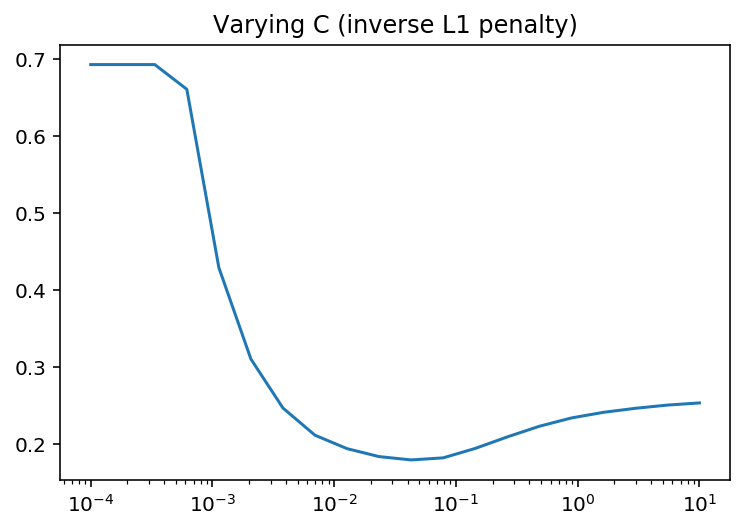

In [16]:
vals = np.logspace(-4,1,20)
out = []
for v in tqdm(vals):
    lmodel = sklearn.linear_model.LogisticRegression(C=v, penalty="l1")
    lmodel.fit(X_strain_imp, y_strain)
    out.append(sklearn.metrics.log_loss(y_valid, lmodel.predict_proba(X_valid_imp)[:,1]))
print("Best L1 Linear model:", np.min(out))
C = vals[np.argmin(out)]

linear_model = sklearn.linear_model.LogisticRegression(C=C, penalty="l1")
linear_model.fit(X_train_imp, y_train)

pl.title("Varying C (inverse L1 penalty)")
pl.semilogx(vals, out)
pl.show()

### SVM Model

In [27]:
# use the C and gamma chosen by the Tune SVM on CRIC Data notebook
svm_model = sklearn.svm.SVC(C=2, gamma=0.0003, probability=True)
svm_model.fit(X_train_imp, y_train)

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0003, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Compute performance metrics

xgb_loss 0.16990688190338027
linear_loss 0.19048939328387
dnn_loss 0.17618095055337252

xgb_roc_auc 0.9660006047873695
linear_roc_auc 0.9618894432773111
dnn_roc_auc 0.9640877657881335
svm_roc_auc 0.9583666563216197

xgb_pr_auc 0.8804480950006923
linear_pr_auc 0.8654731495129078
dnn_pr_auc 0.874898438817953
svm_pr_auc 0.8572866277744448



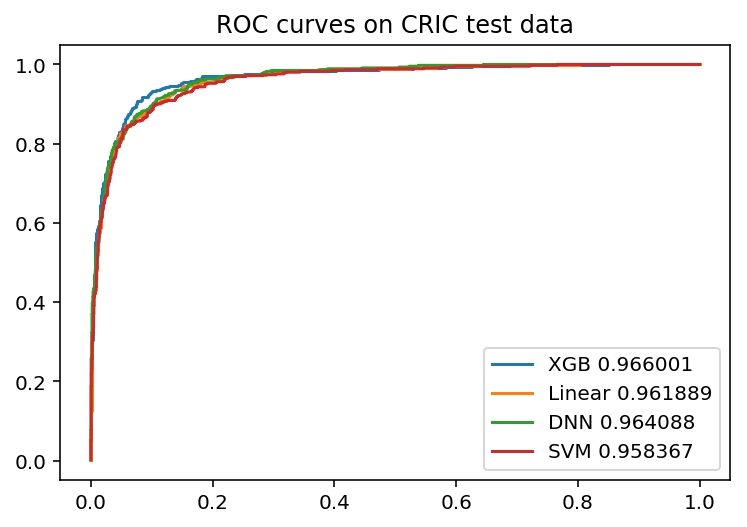

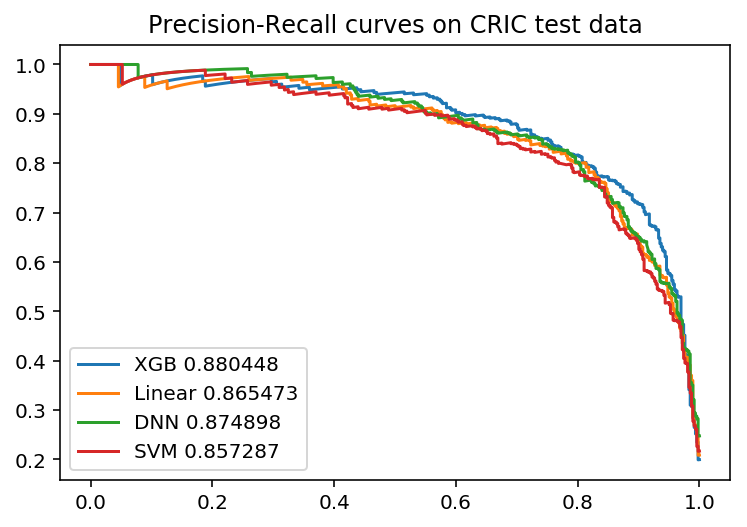

In [37]:
xgb_loss = sklearn.metrics.log_loss(y_test, xgb_model.predict_proba(X_test)[:,1])
linear_loss = sklearn.metrics.log_loss(y_test, linear_model.predict_proba(X_test_imp)[:,1])
dnn_loss = sklearn.metrics.log_loss(y_test, dnn_model.predict(X_test_imp))
constant_loss = sklearn.metrics.log_loss(y_test, np.zeros(len(y_test)) * y_strain.mean())
print("xgb_loss", xgb_loss)
print("linear_loss", linear_loss)
print("dnn_loss", dnn_loss)
print()

xgb_roc_auc = sklearn.metrics.roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1])
linear_roc_auc = sklearn.metrics.roc_auc_score(y_test, linear_model.predict_proba(X_test_imp)[:,1])
dnn_roc_auc = sklearn.metrics.roc_auc_score(y_test, dnn_model.predict(X_test_imp))
svm_roc_auc = sklearn.metrics.roc_auc_score(y_test, svm_model.predict_proba(X_test_imp)[:,1])
print("xgb_roc_auc", xgb_roc_auc)
print("linear_roc_auc", linear_roc_auc)
print("dnn_roc_auc", dnn_roc_auc)
print("svm_roc_auc", svm_roc_auc)
print()

xgb_pr_auc = sklearn.metrics.average_precision_score(y_test, xgb_model.predict_proba(X_test)[:,1])
linear_pr_auc = sklearn.metrics.average_precision_score(y_test, linear_model.predict_proba(X_test_imp)[:,1])
dnn_pr_auc = sklearn.metrics.average_precision_score(y_test, dnn_model.predict(X_test_imp))
svm_pr_auc = sklearn.metrics.average_precision_score(y_test, svm_model.predict_proba(X_test_imp)[:,1])
print("xgb_pr_auc", xgb_pr_auc)
print("linear_pr_auc", linear_pr_auc)
print("dnn_pr_auc", dnn_pr_auc)
print("svm_pr_auc", svm_pr_auc)
print()

xgb_fpr, xgb_tpr, thresholds = sklearn.metrics.roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
linear_fpr, linear_tpr, thresholds = sklearn.metrics.roc_curve(y_test, linear_model.predict_proba(X_test_imp)[:,1])
dnn_fpr, dnn_tpr, thresholds = sklearn.metrics.roc_curve(y_test, dnn_model.predict(X_test_imp))
svm_fpr, svm_tpr, thresholds = sklearn.metrics.roc_curve(y_test, svm_model.predict_proba(X_test_imp)[:,1])


pl.plot(xgb_fpr, xgb_tpr, label="XGB %f" % xgb_roc_auc)
pl.plot(linear_fpr, linear_tpr, label="Linear %f" % linear_roc_auc)
pl.plot(dnn_fpr, dnn_tpr, label="DNN %f" % dnn_roc_auc)
pl.plot(svm_fpr, svm_tpr, label="SVM %f" % svm_roc_auc)
pl.legend()
pl.title("ROC curves on CRIC test data")
pl.show()

xgb_prec, xgb_recall, thresholds = sklearn.metrics.precision_recall_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
linear_prec, linear_recall, thresholds = sklearn.metrics.precision_recall_curve(y_test, linear_model.predict_proba(X_test_imp)[:,1])
dnn_prec, dnn_recall, thresholds = sklearn.metrics.precision_recall_curve(y_test, dnn_model.predict(X_test_imp))
svm_prec, svm_recall, thresholds = sklearn.metrics.precision_recall_curve(y_test, svm_model.predict_proba(X_test_imp)[:,1])

pl.plot(xgb_recall, xgb_prec, label="XGB %f" % xgb_pr_auc)
pl.plot(linear_recall, linear_prec, label="Linear %f" % linear_pr_auc)
pl.plot(dnn_recall, dnn_prec, label="DNN %f" % dnn_pr_auc)
pl.plot(svm_recall, svm_prec, label="SVM %f" % svm_pr_auc)
pl.legend()
pl.title("Precision-Recall curves on CRIC test data")
pl.show()

## Build summary plots

In [29]:
xgb_shap = shap.TreeExplainer(xgb_model).shap_values(X)

In [6]:
# bg = sklearn.utils.resample(X_train, n_samples=100, replace=False)
# xgb_shap_ind = shap.TreeExplainer(xgb_model, bg, feature_dependence="independent").shap_values(X_test.iloc[:,:])

In [125]:
xgb_shap_interaction = shap.TreeExplainer(xgb_model).shap_interaction_values(X)

In [128]:
np.save("data/cric_xgb_shap_interaction.npy", xgb_shap_interaction)

In [126]:
xgb_shap_interaction

(10745, 333, 333)

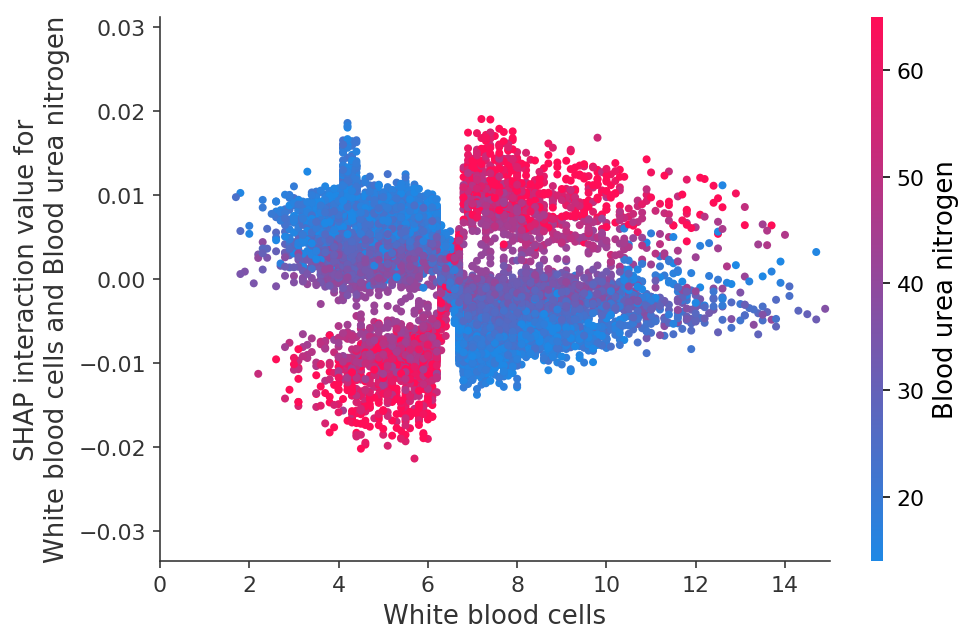

In [134]:
shap.dependence_plot(("White blood cells", "Blood urea nitrogen"), xgb_shap_interaction, X, feature_names=np.array(mapped_feature_names), show=False)
pl.xlim(0,15)
pl.savefig("raw_figures/cric_wbc_bun_interaction.pdf", dpi=400)
pl.show()

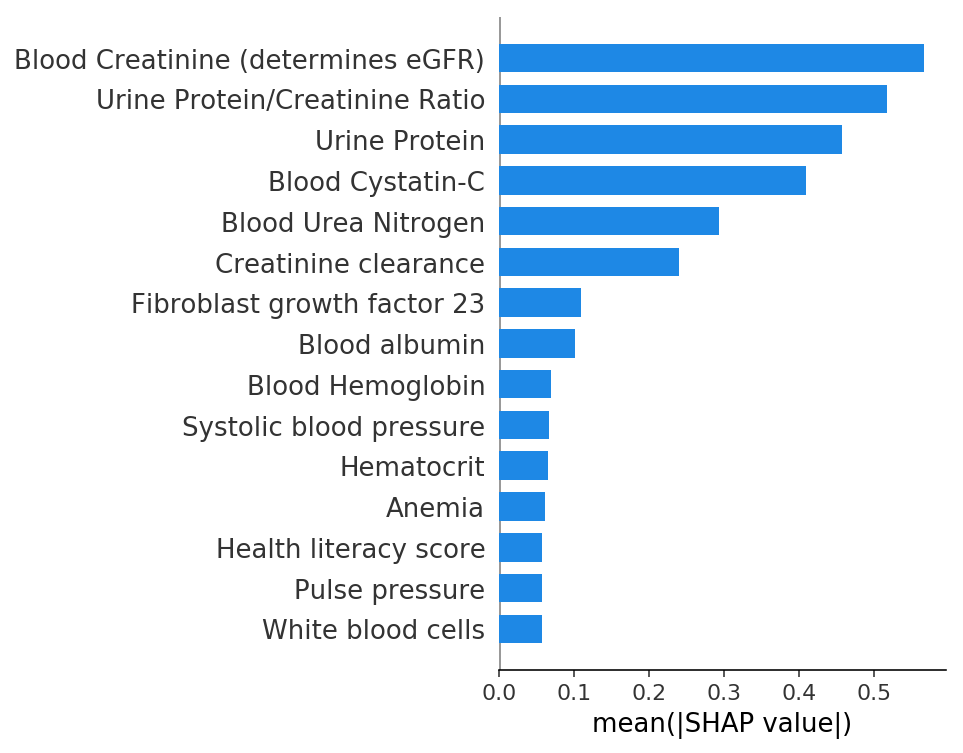

In [55]:
f = pl.figure(figsize=(4,6))
shap.summary_plot(
    xgb_shap, X, feature_names=mapped_feature_names, plot_type="bar",
    max_display=15, auto_size_plot=False, show=False
)
pl.xlabel("mean(|SHAP value|)")
pl.savefig("raw_figures/summary_bar.pdf", dpi=400)
pl.show()

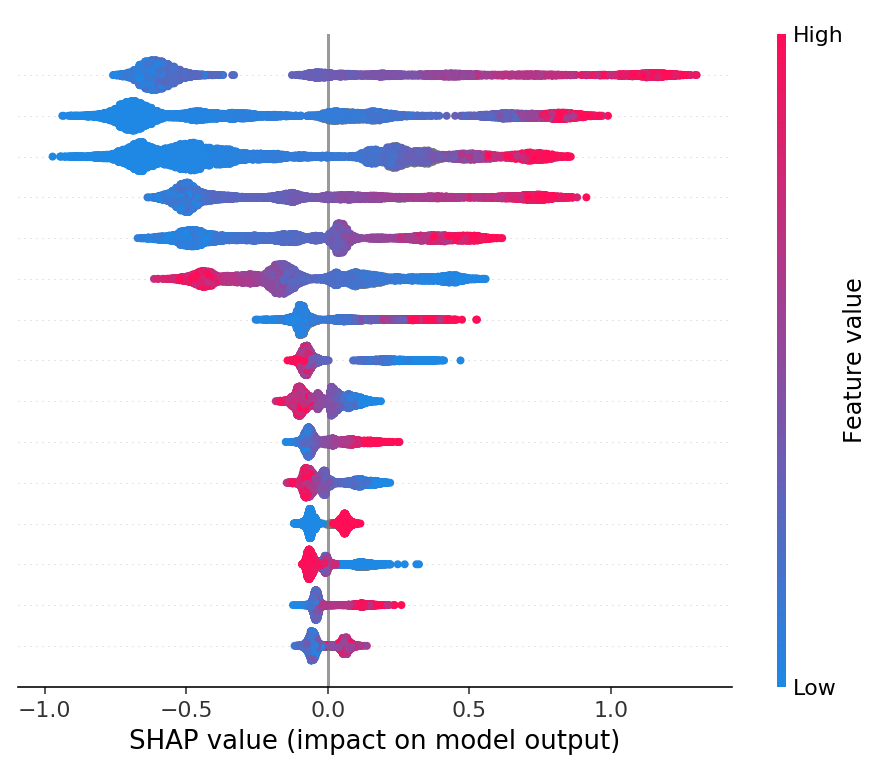

In [63]:
f = pl.figure(figsize=(8,6))
shap.summary_plot(
    xgb_shap, X, feature_names=["" for m in mapped_feature_names], plot_type="dot",
    max_display=15, auto_size_plot=False, show=False
)
pl.savefig("raw_figures/summary_dot.pdf", dpi=400)
pl.show()

## Build embedding plots

In [77]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

np.random.seed(0)
#shap_pca = PCA(n_components=20).fit_transform(xgb_shap)
#shap_tsne = TSNE(n_components=2, perplexity=50, random_state=0).fit_transform(xgb_shap[:2000,:])
shap_pca = PCA(n_components=2).fit_transform(xgb_shap)
raw_pca = PCA(n_components=2).fit_transform(X_imp)

In [92]:
shap_pca.shape

(10745, 2)

In [78]:
def embedding_plot(embedding, values, label, alpha=1.0, show=True):
    f = pl.figure(figsize=(5,5))
    pl.scatter(embedding[:,0],
               embedding[:,1],
               c=values,
               linewidth=0, alpha=alpha, cmap=shap.plots.colors.red_blue_solid)
    cb = pl.colorbar(label=label, aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    pl.gca().axis("off")
    if show:
        pl.show()

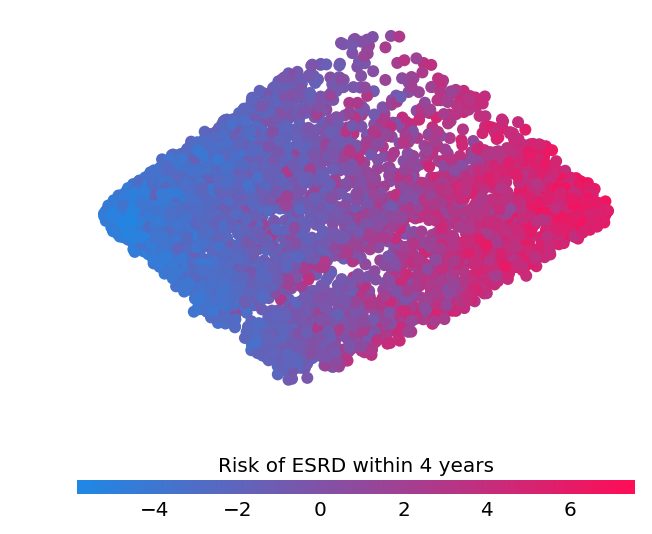

In [80]:
embedding_plot(shap_pca, xgb_shap.sum(1), "Risk of ESRD within 4 years", show=False)
pl.savefig("raw_figures/kidney_shap_pca_risk.pdf", dpi=400)
pl.show()

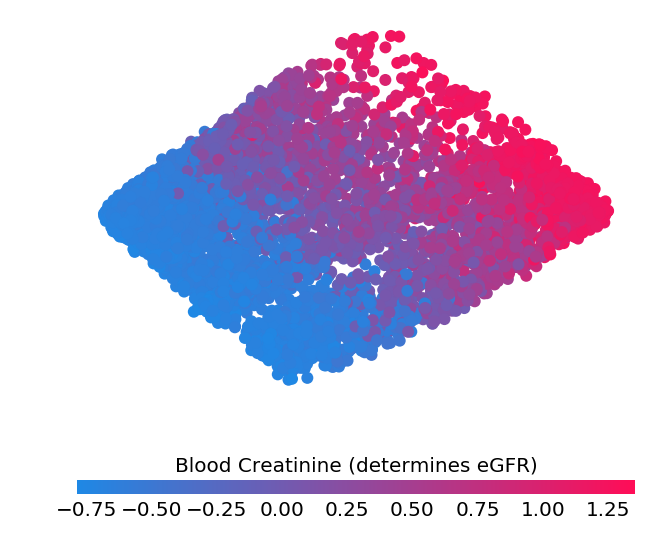

In [81]:
embedding_plot(shap_pca, xgb_shap[:,53], mapped_feature_names[53], show=False)
pl.savefig("raw_figures/kidney_shap_pca_creatinine.pdf", dpi=400)
pl.show()

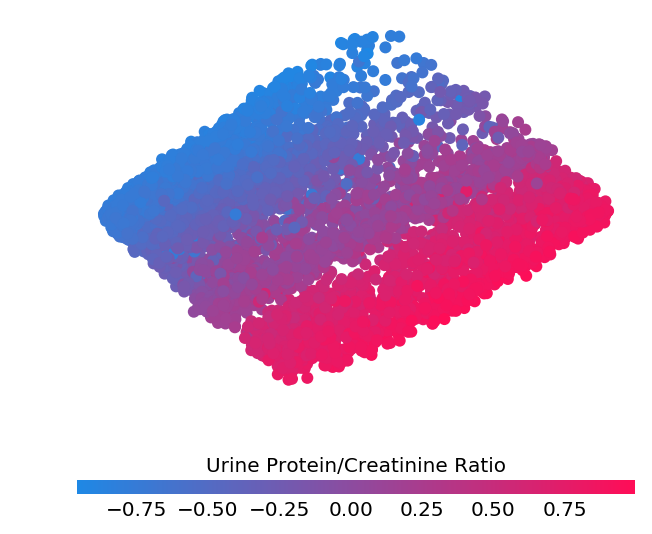

In [82]:
embedding_plot(shap_pca, xgb_shap[:,330], mapped_feature_names[330], show=False)
pl.savefig("raw_figures/kidney_shap_pca_pcr.pdf", dpi=400)
pl.show()

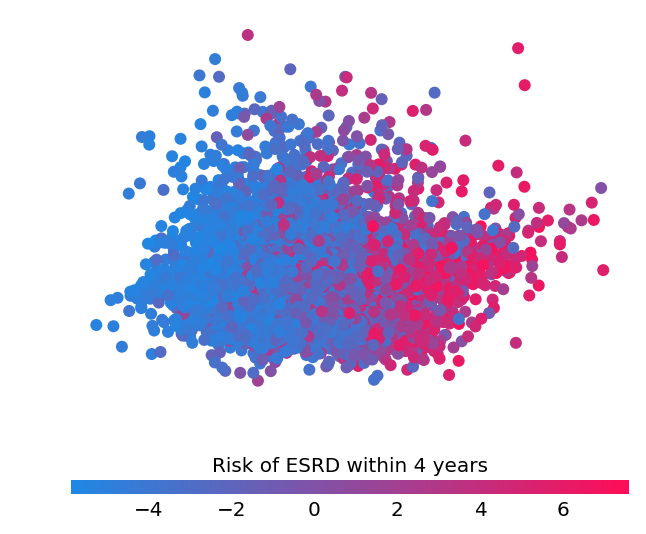

In [83]:
embedding_plot(raw_pca, xgb_shap.sum(1), "Risk of ESRD within 4 years", show=False)
pl.savefig("raw_figures/kidney_raw_pca_risk.pdf", dpi=400)
pl.show()

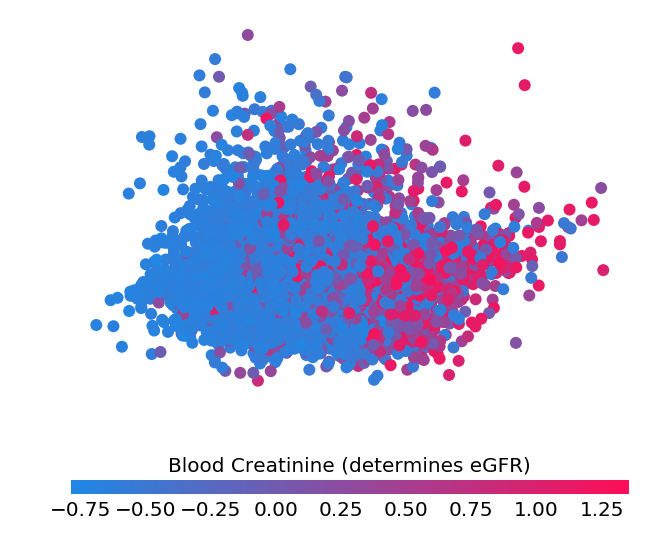

In [84]:
embedding_plot(raw_pca, xgb_shap[:,53], mapped_feature_names[53], show=False)
pl.savefig("raw_figures/kidney_raw_pca_creatinine.pdf", dpi=400)
pl.show()

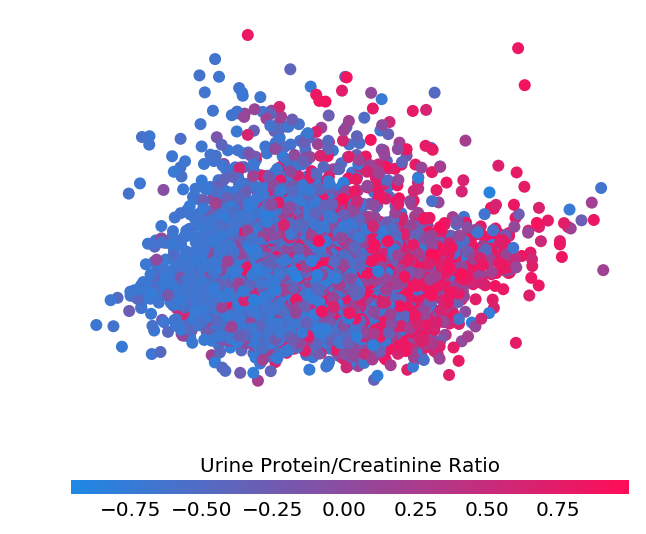

In [85]:
embedding_plot(raw_pca, xgb_shap[:,330], mapped_feature_names[330], show=False)
pl.savefig("raw_figures/kidney_raw_pca_pcr.pdf", dpi=400)
pl.show()

## Dependence plots

In [124]:
# make sure the auto-detected interaction index is right
ind = np.where(np.array(mapped_feature_names) == "Systolic blood pressure")[0][0]
mapped_feature_names[np.argsort(-np.abs(xgb_shap_interaction).sum(0)[ind,:])[1]]

'Blood urea nitrogen'

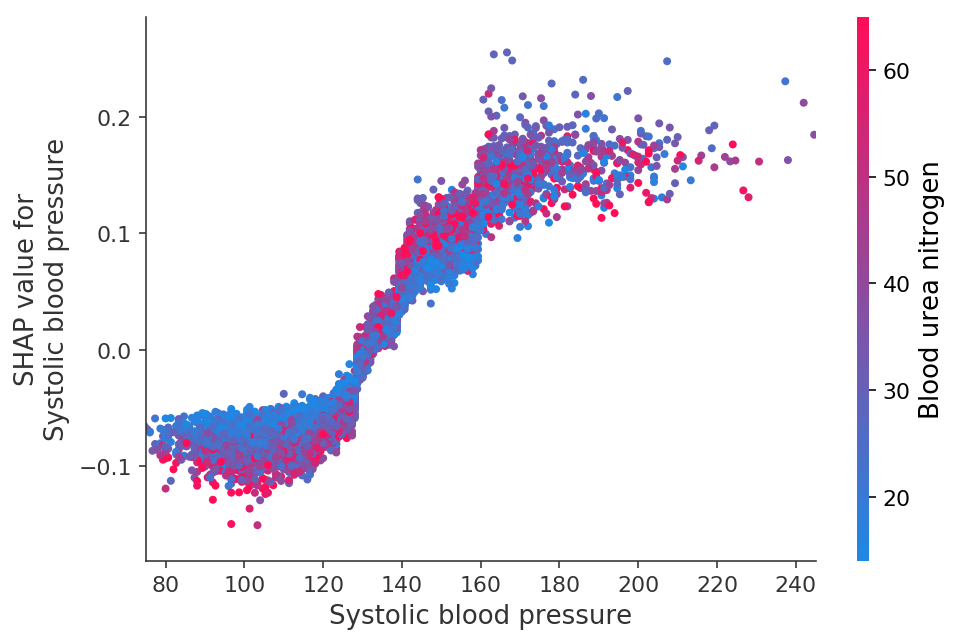

In [115]:
shap.dependence_plot("Systolic blood pressure", xgb_shap, X, show=False, feature_names=np.array(mapped_feature_names), interaction_index="auto")
pl.xlim(75, 245)
#pl.xlabel("Systolic blood pressure")
pl.savefig("raw_figures/kidney_dependence_SYSTOLIC.pdf", dpi=400)
pl.show()

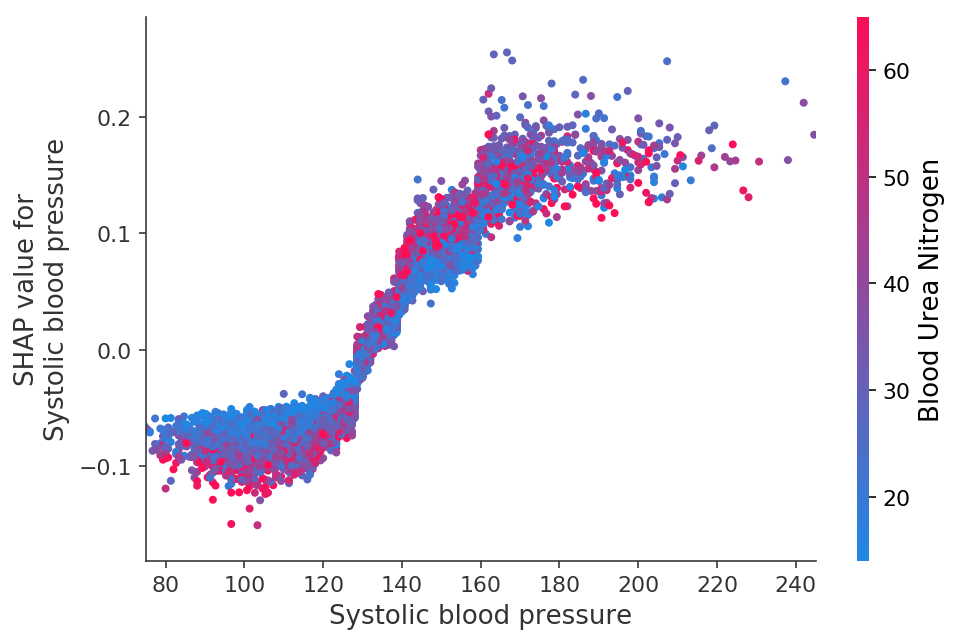

In [112]:
shap.dependence_plot("Systolic blood pressure", xgb_shap, X, show=False, feature_names=np.array(mapped_feature_names), interaction_index="auto")
pl.xlim(75, 245)
#pl.xlabel("Systolic blood pressure")
pl.savefig("raw_figures/kidney_dependence_SYSTOLIC.pdf", dpi=400)
pl.show()

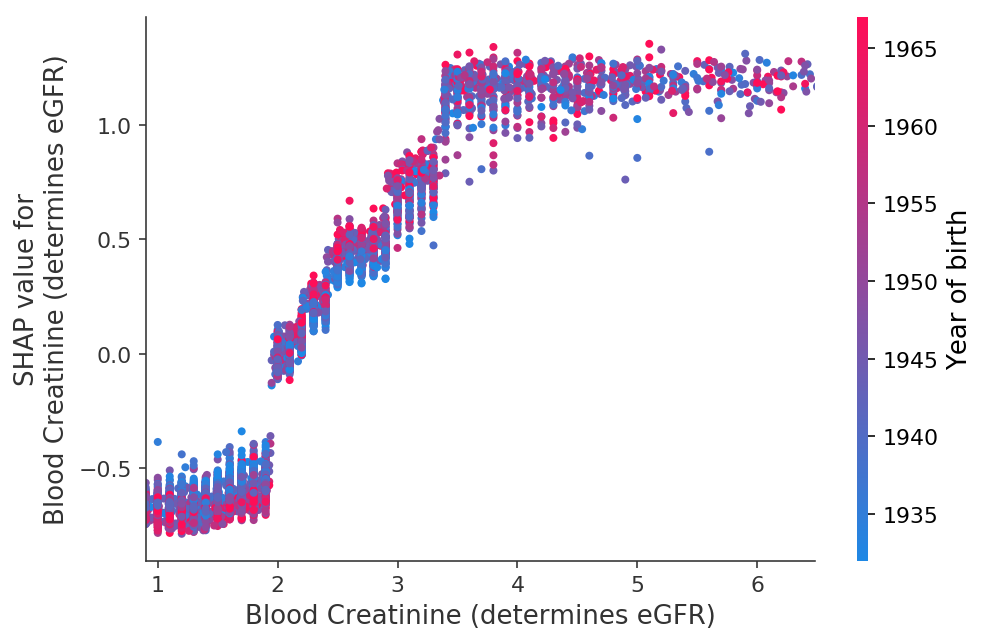

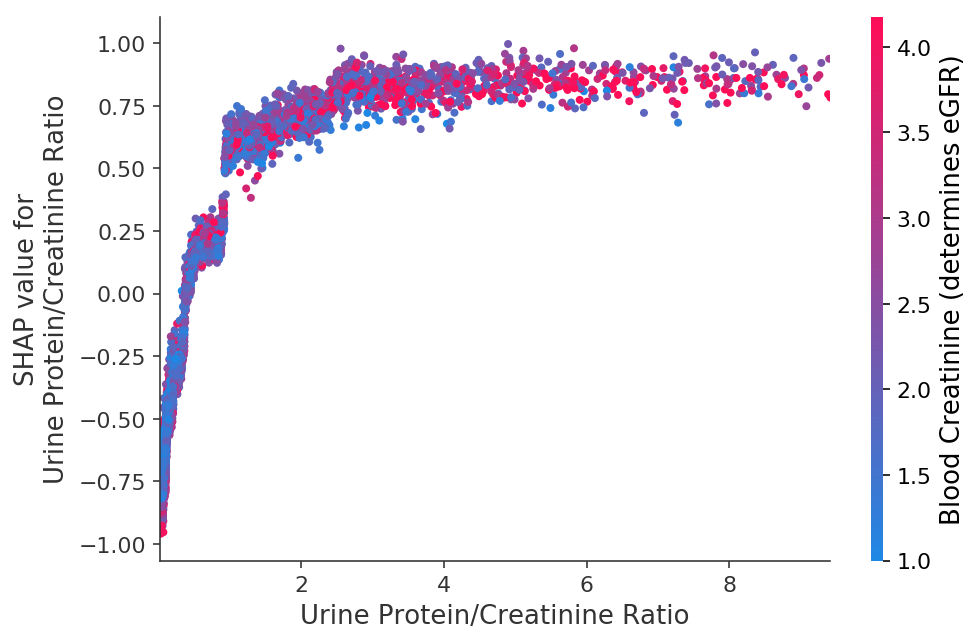

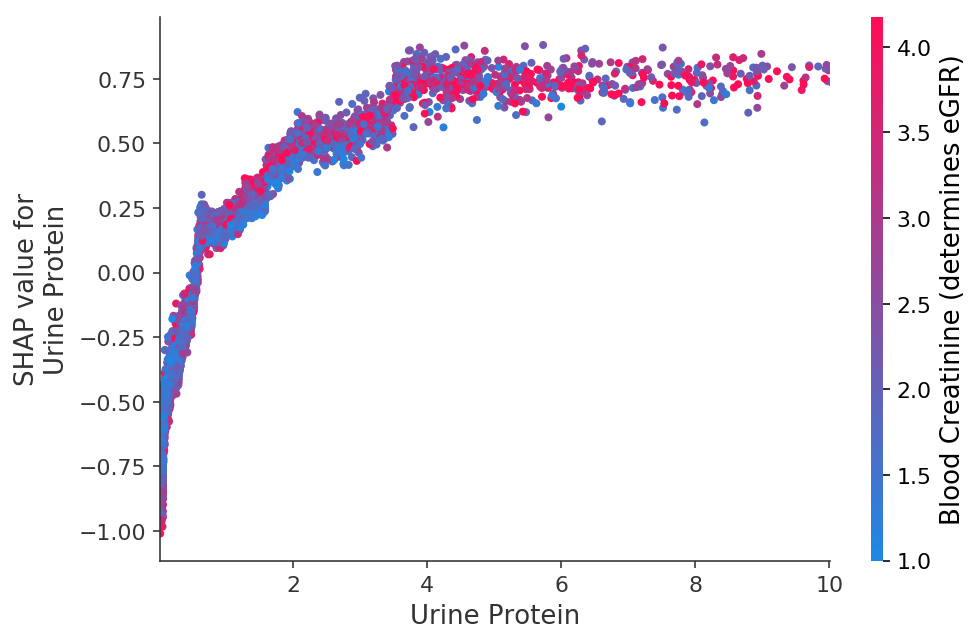

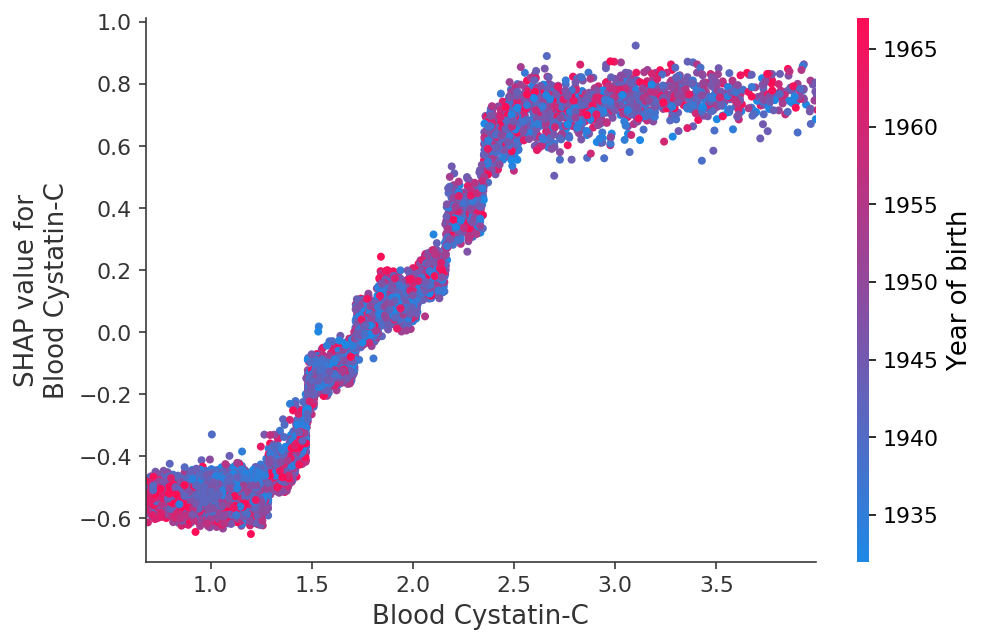

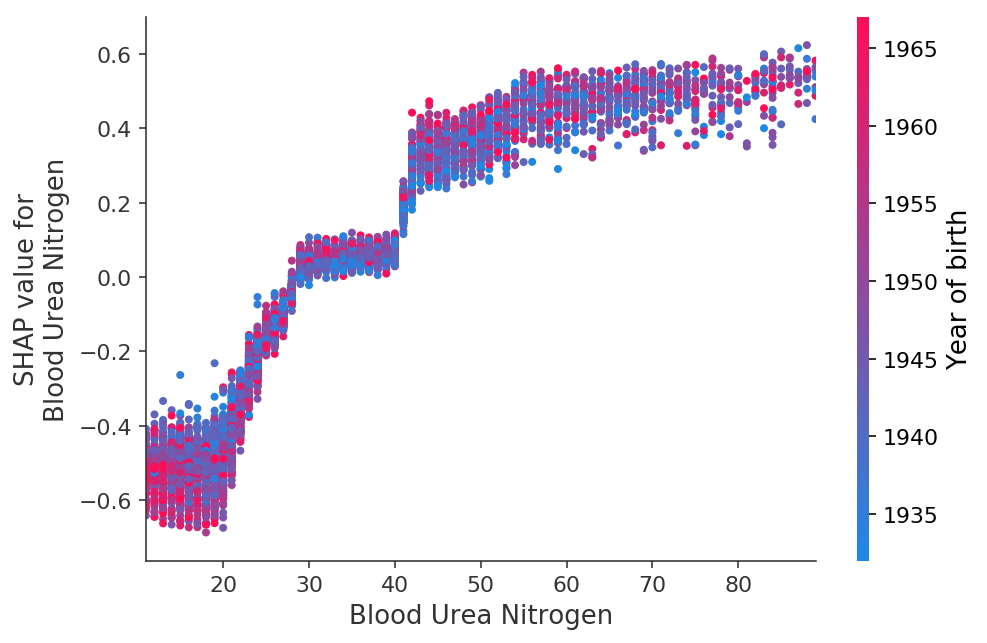

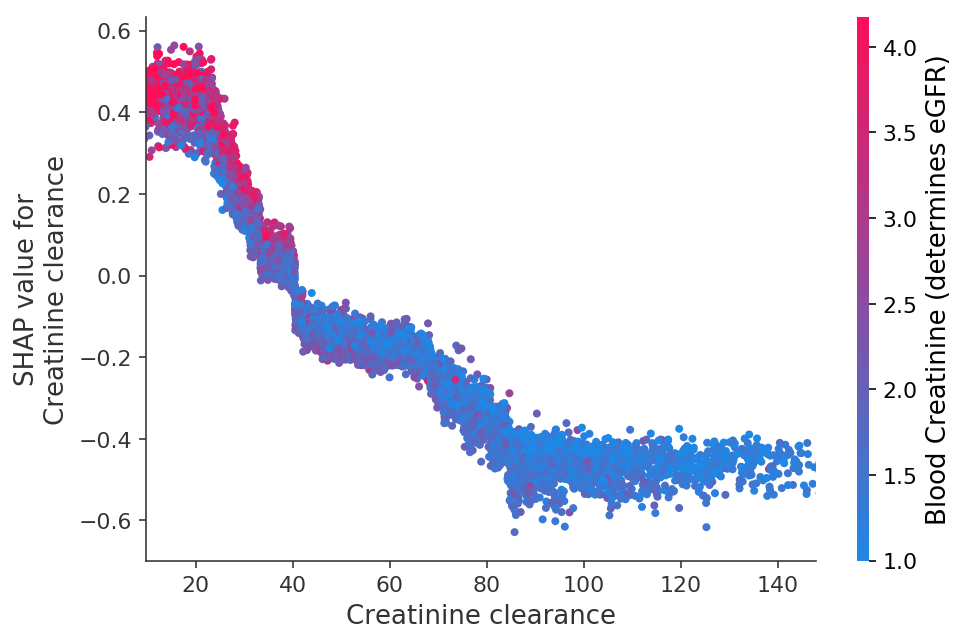

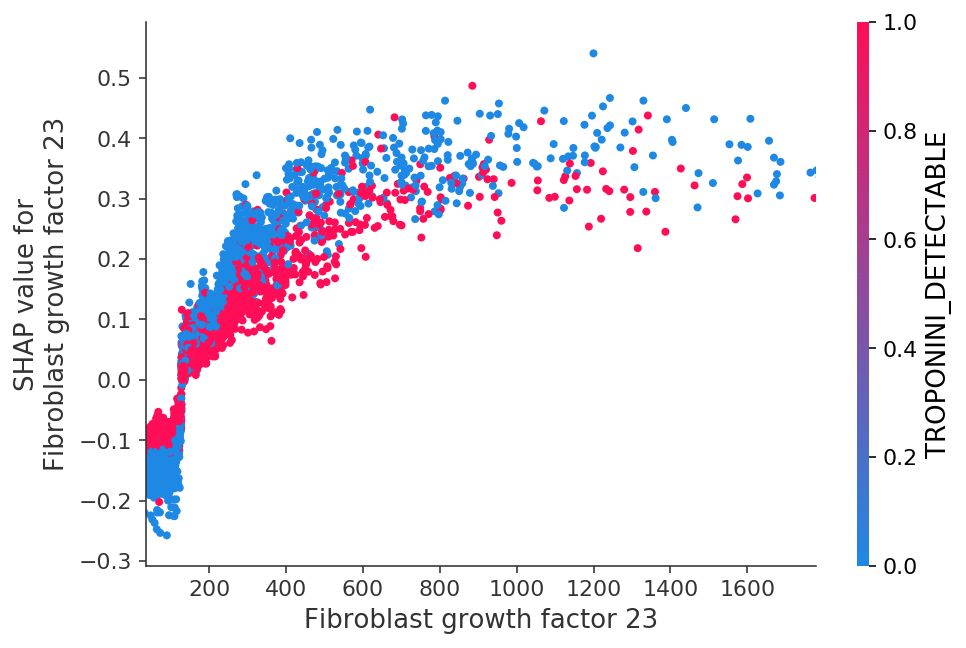

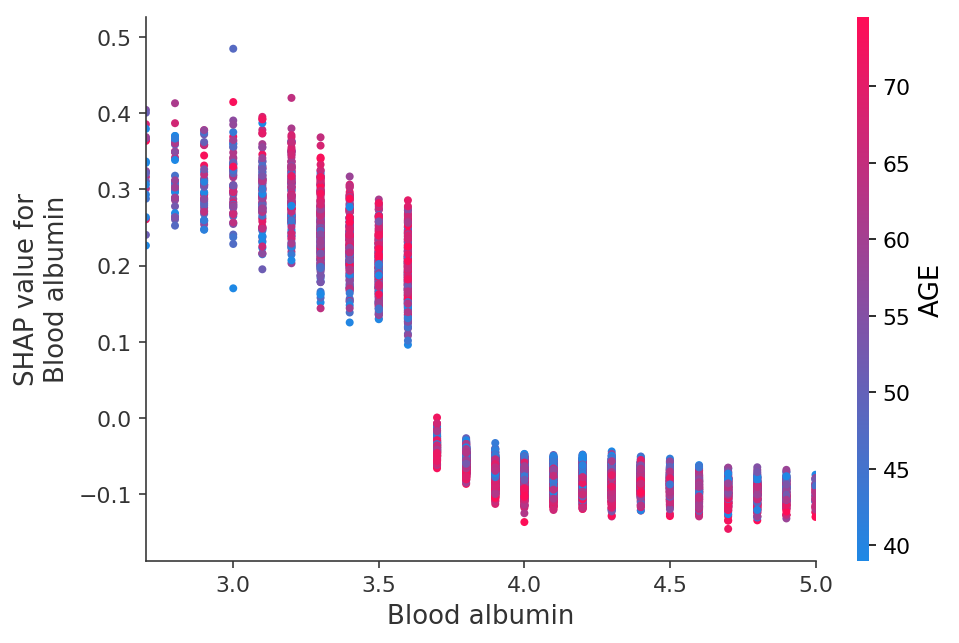

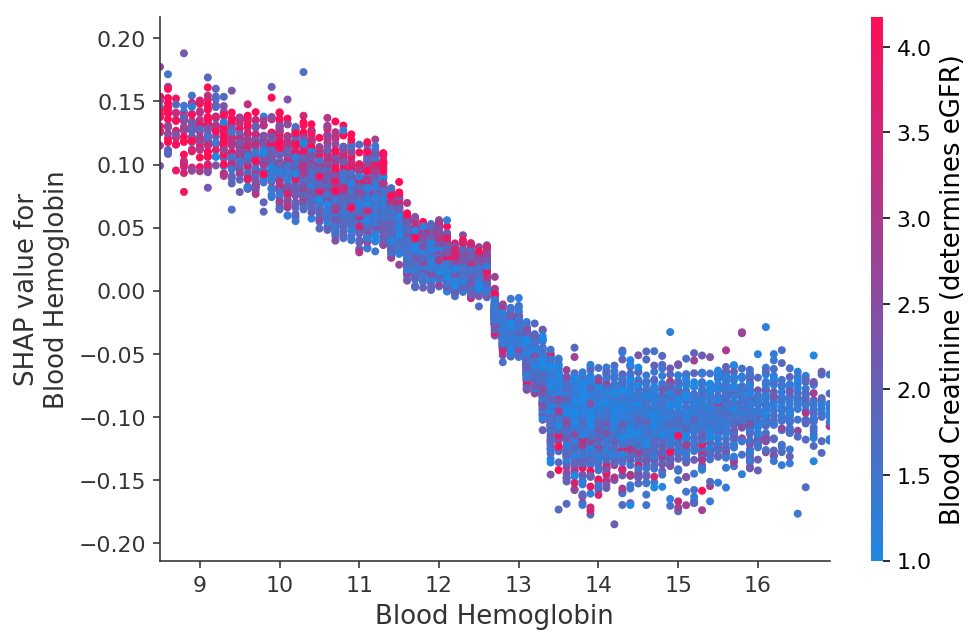

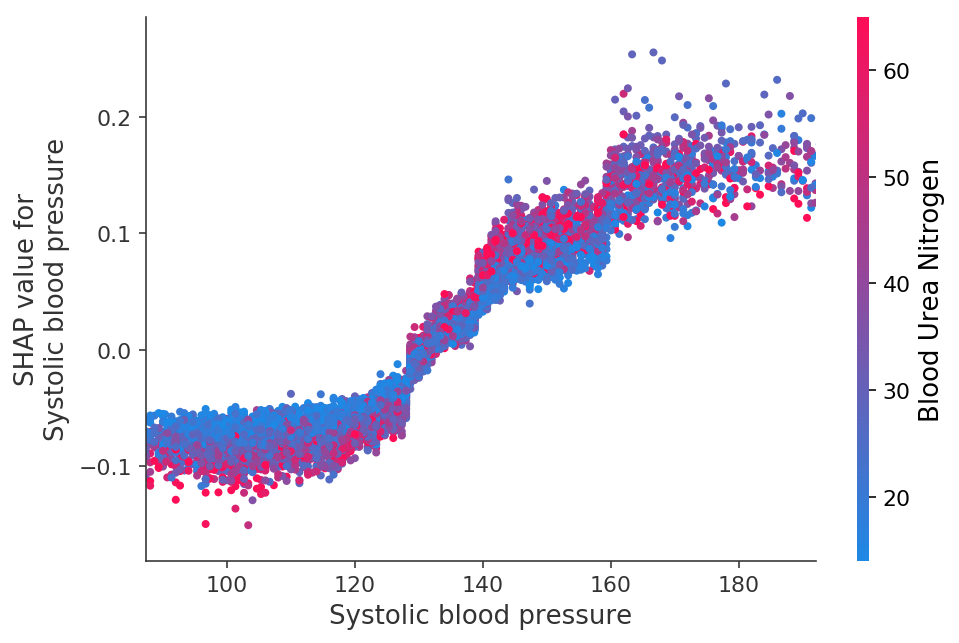

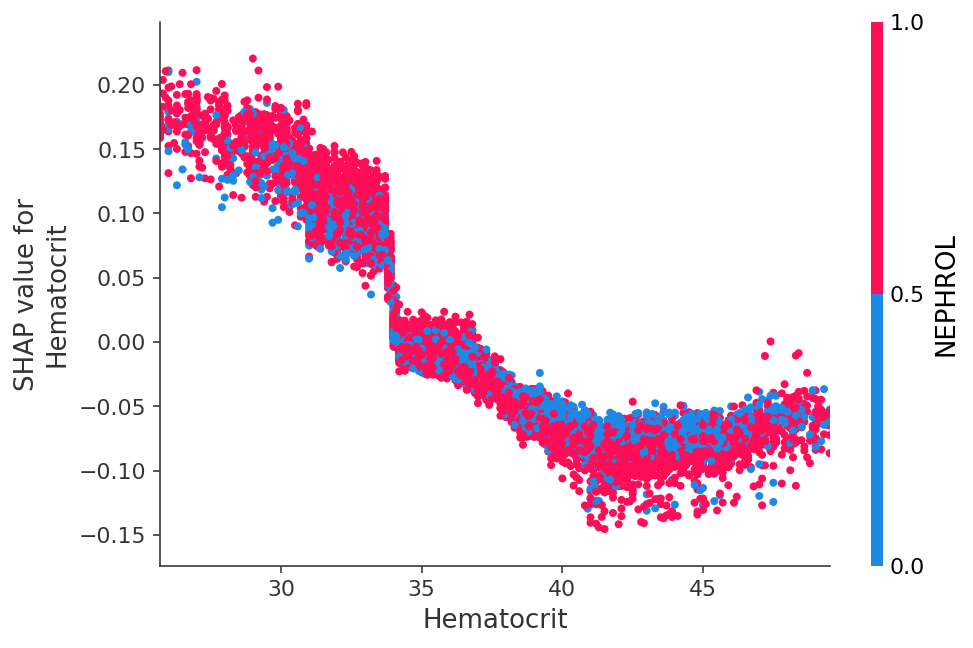

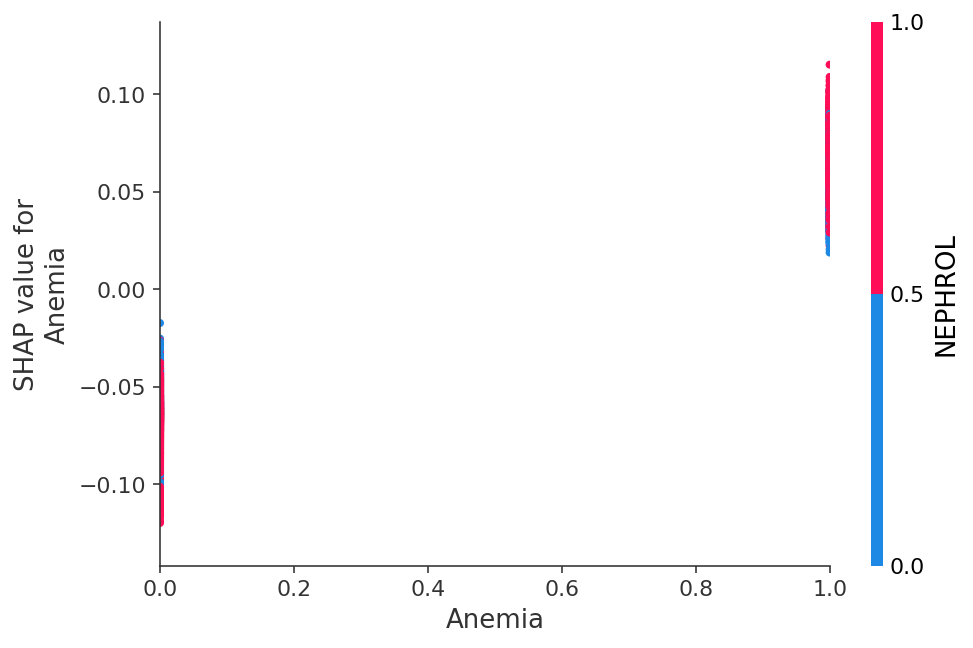

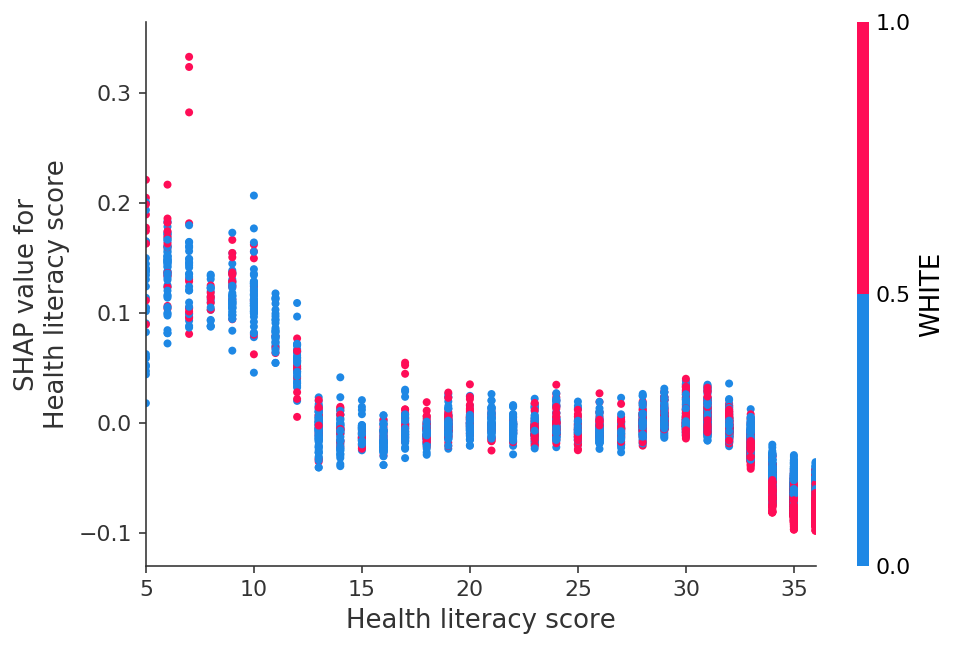

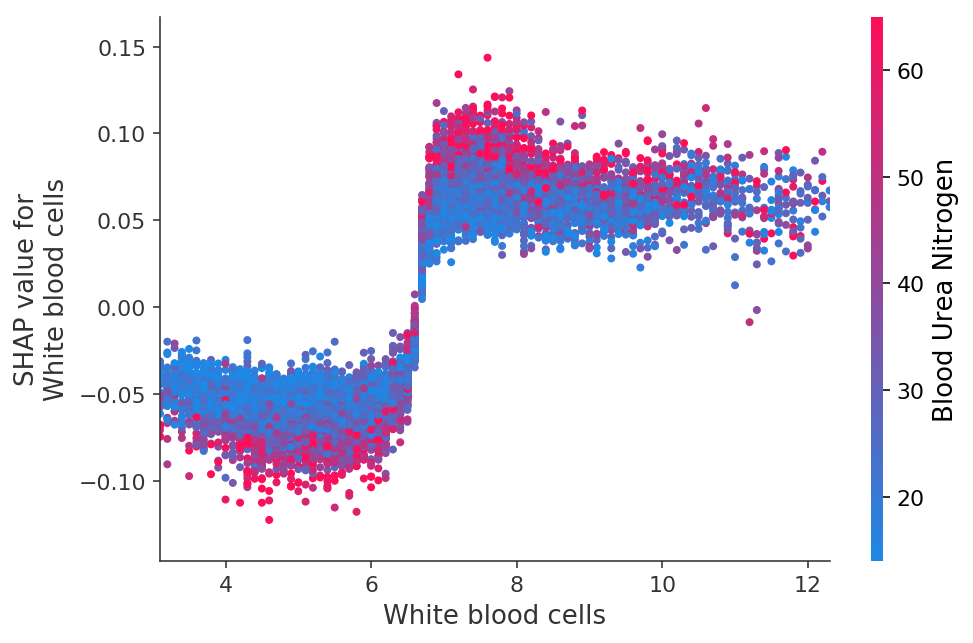

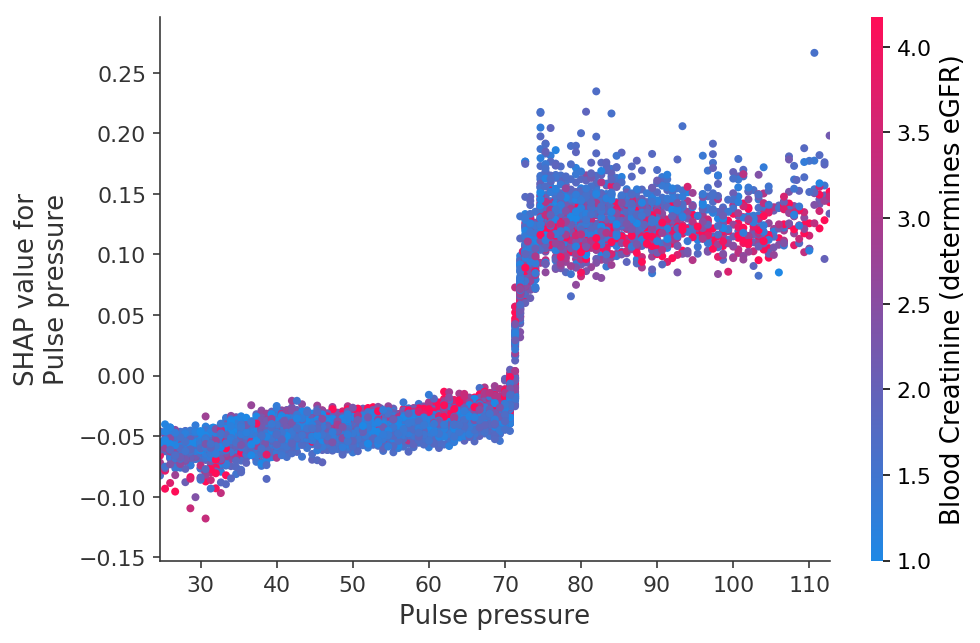

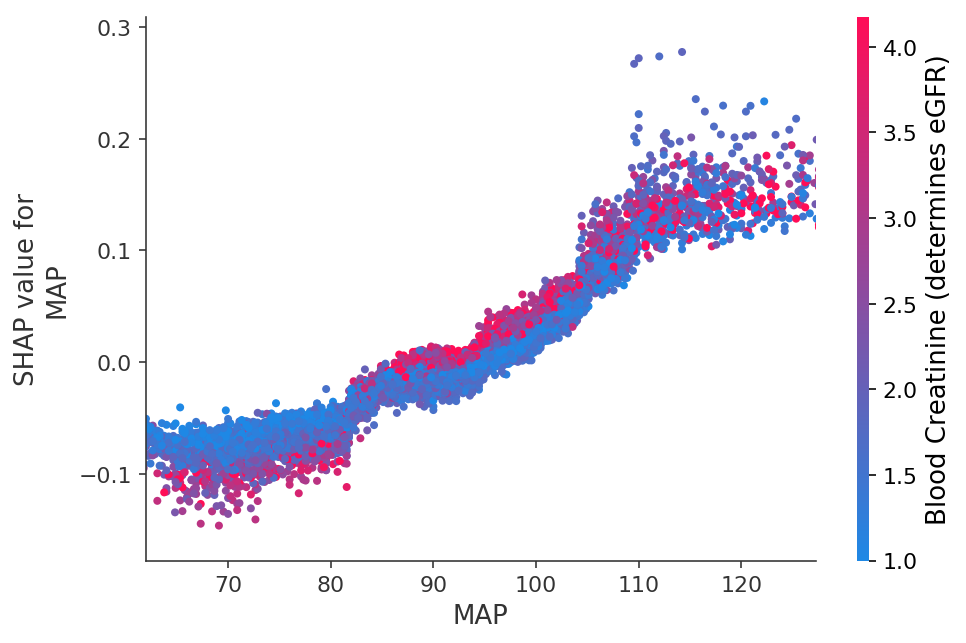

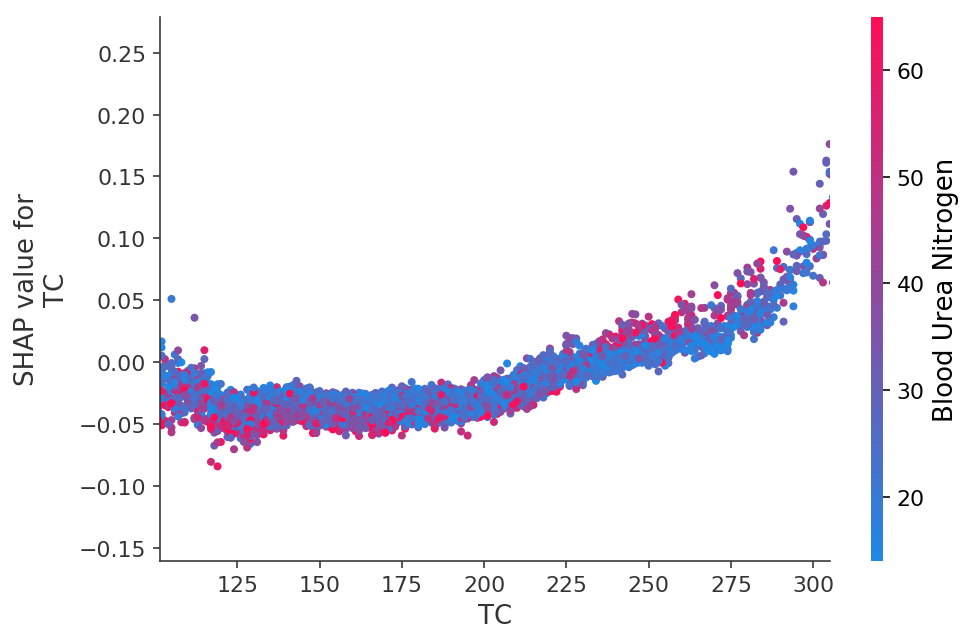

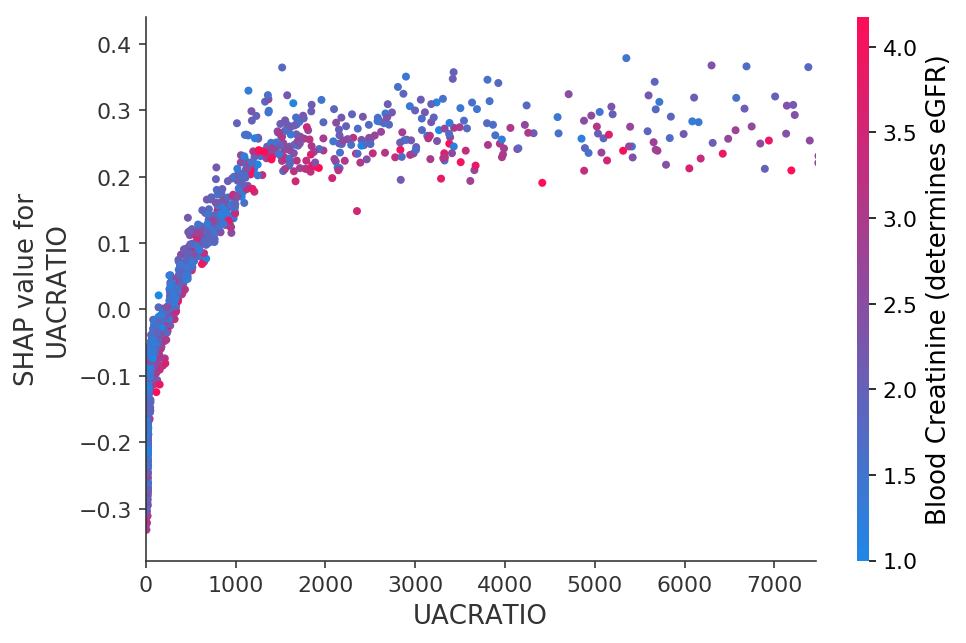

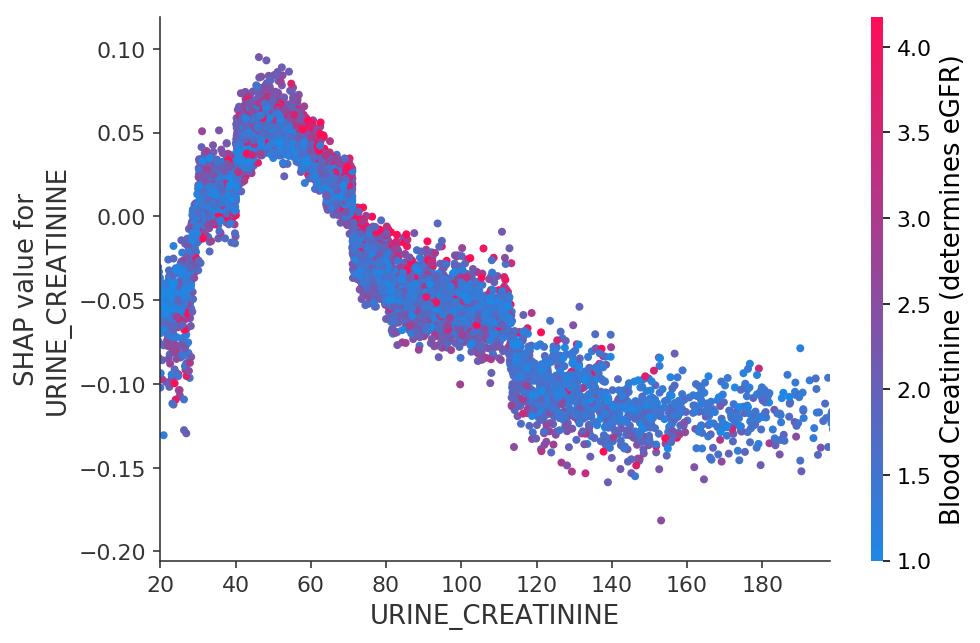

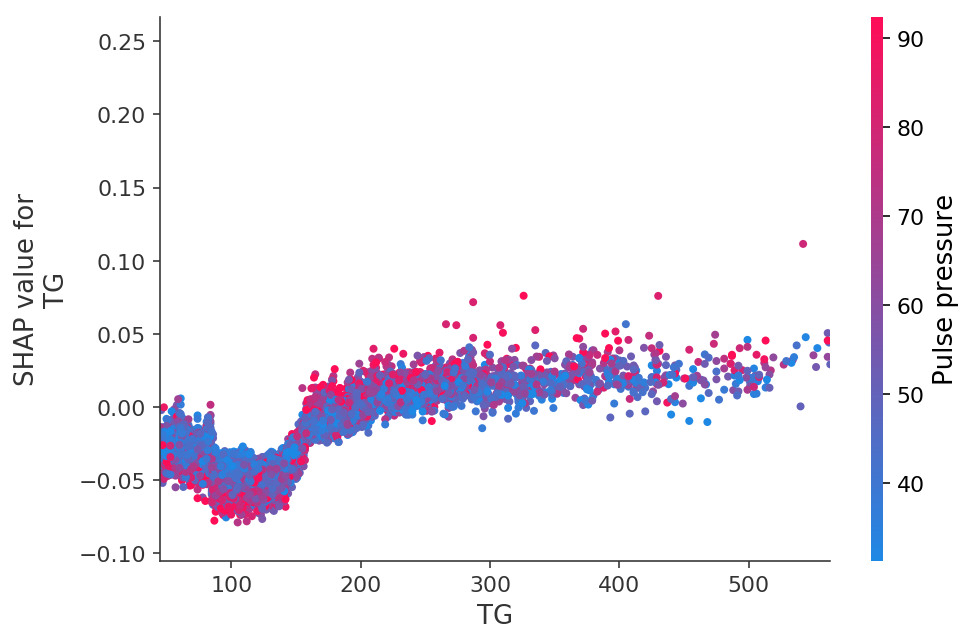

In [88]:
for i in np.argsort(-np.abs(xgb_shap).mean(0))[:20]:
    shap.dependence_plot(i, xgb_shap, X, feature_names=mapped_feature_names, show=False)
    pl.xlim(np.nanpercentile(X.values[:,i], 1), np.nanpercentile(X.values[:,i], 99))
    pl.savefig("raw_figures/kidney_dependence_"+X.columns[i]+".pdf", dpi=400)
    pl.show()

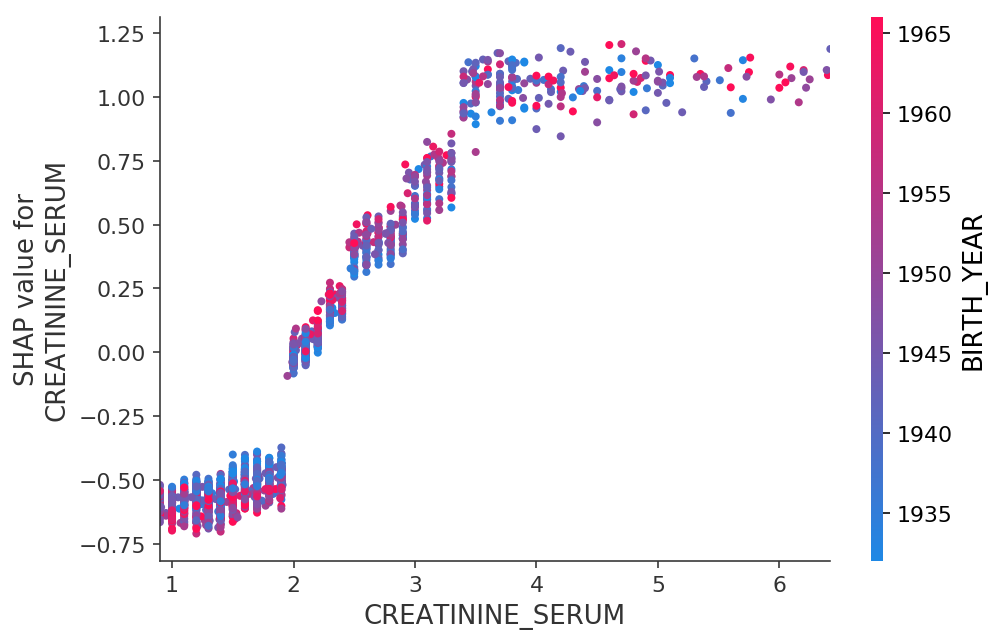

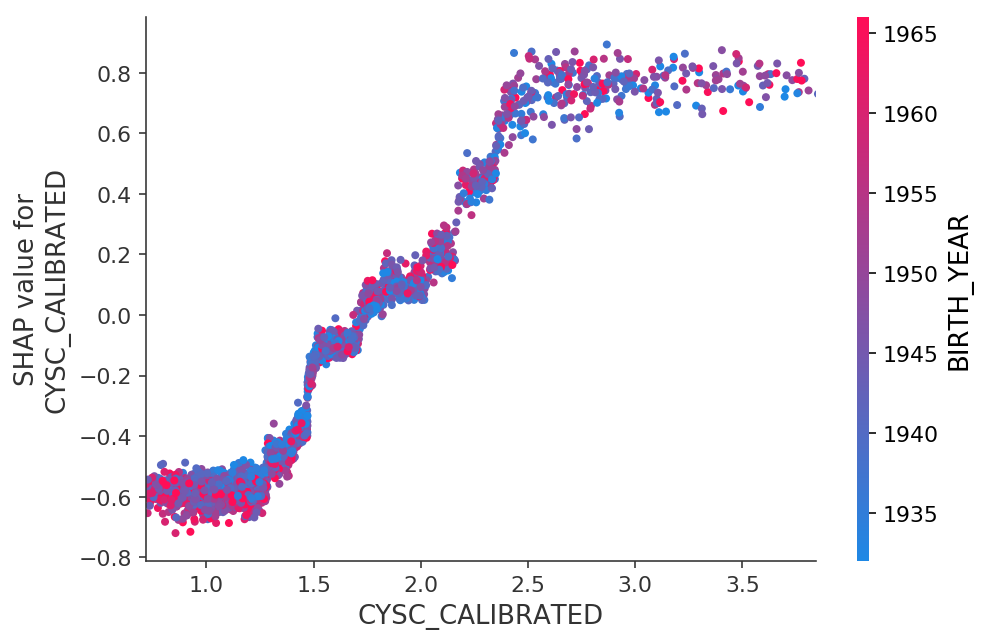

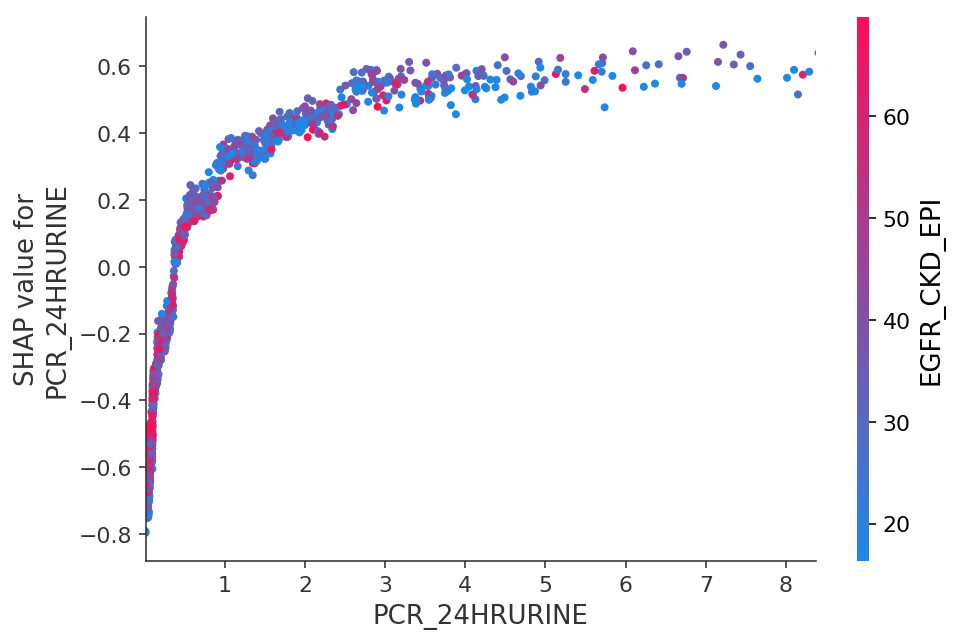

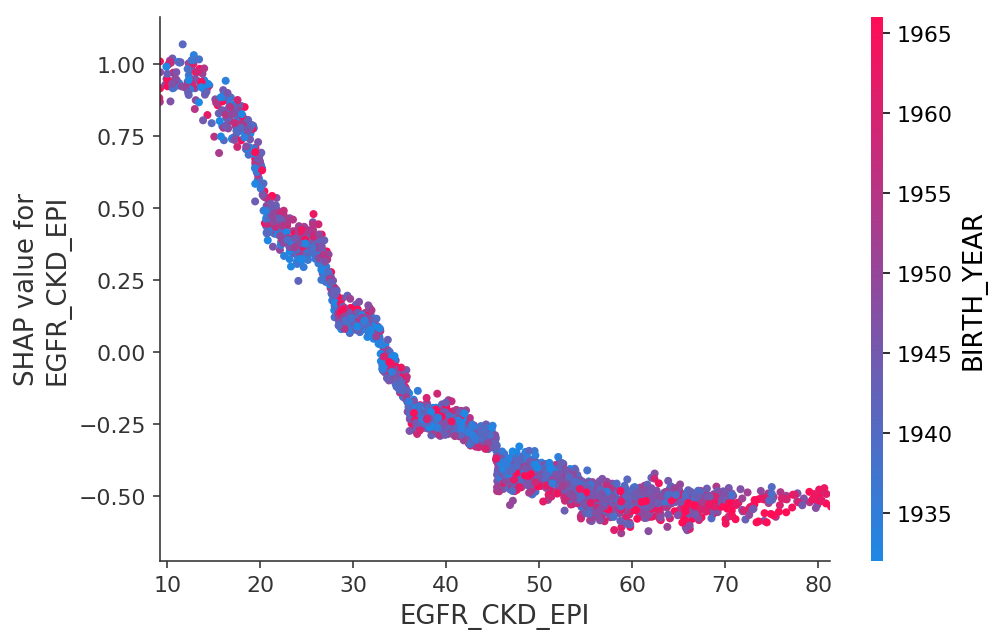

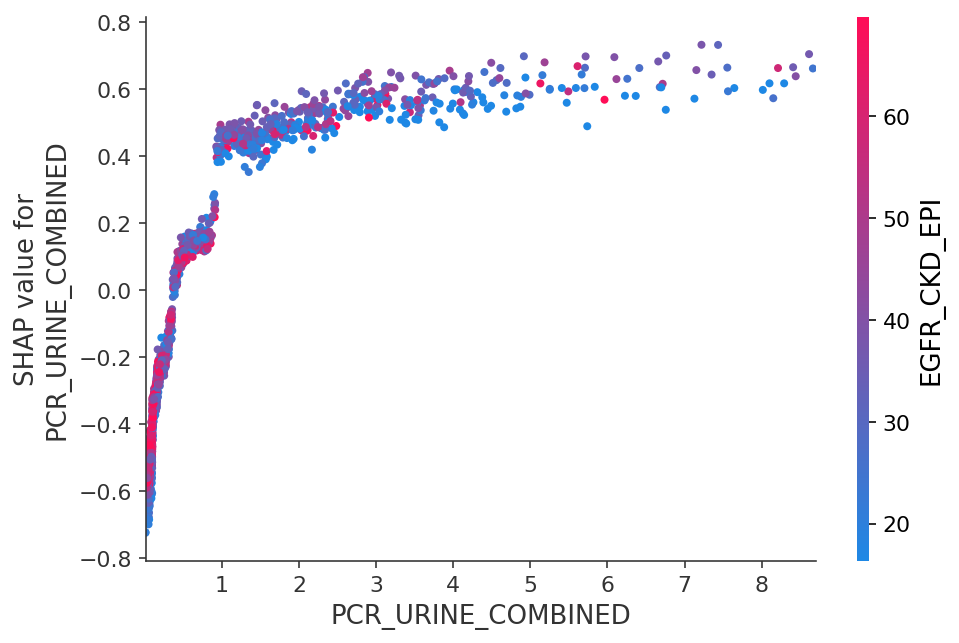

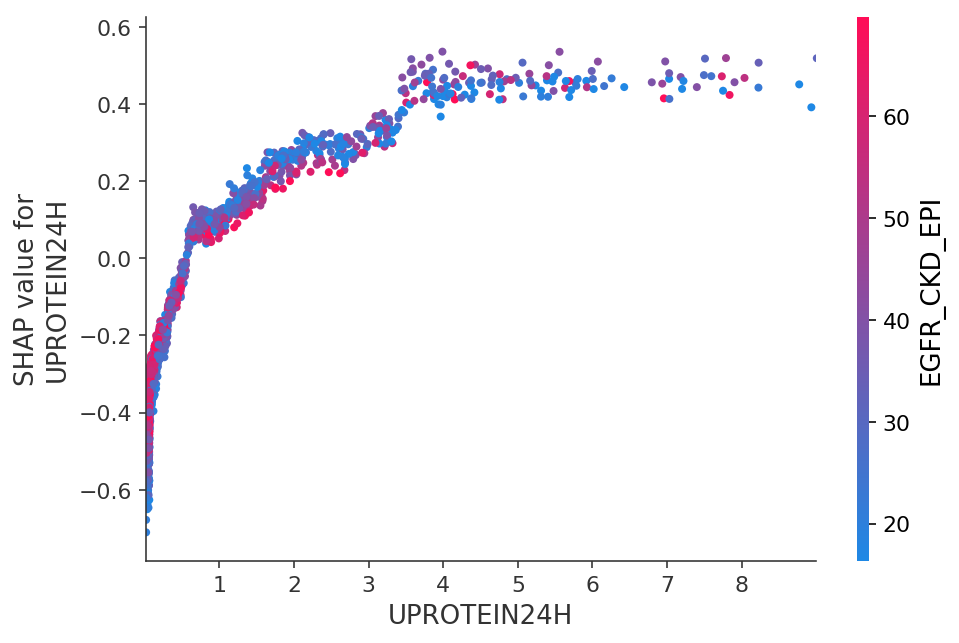

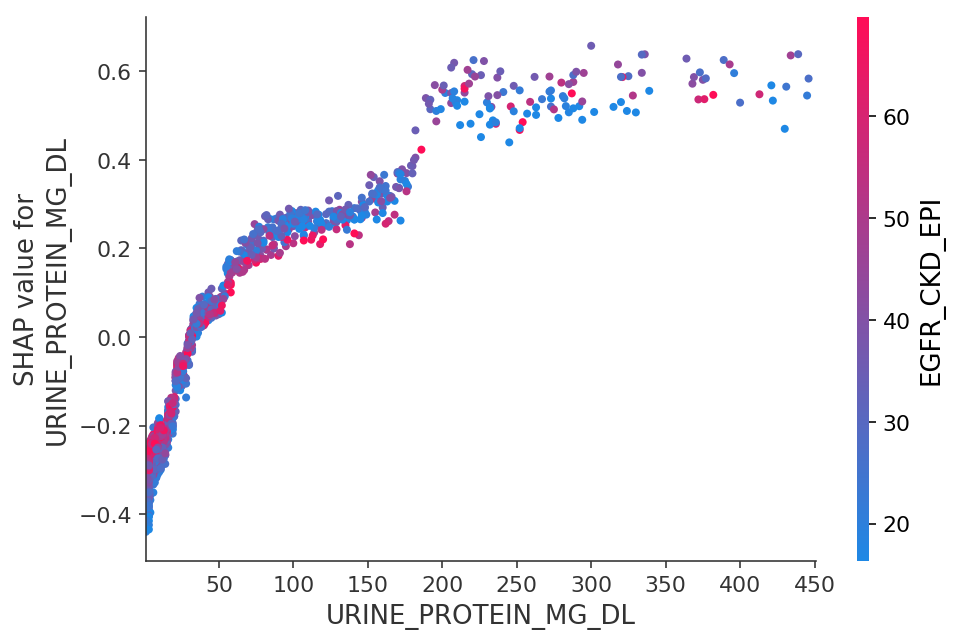

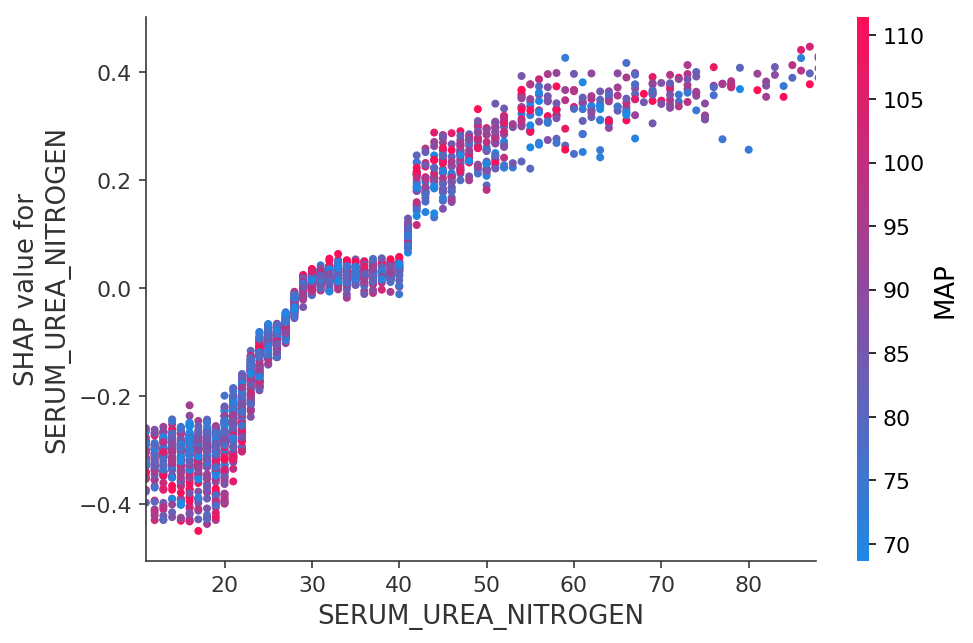

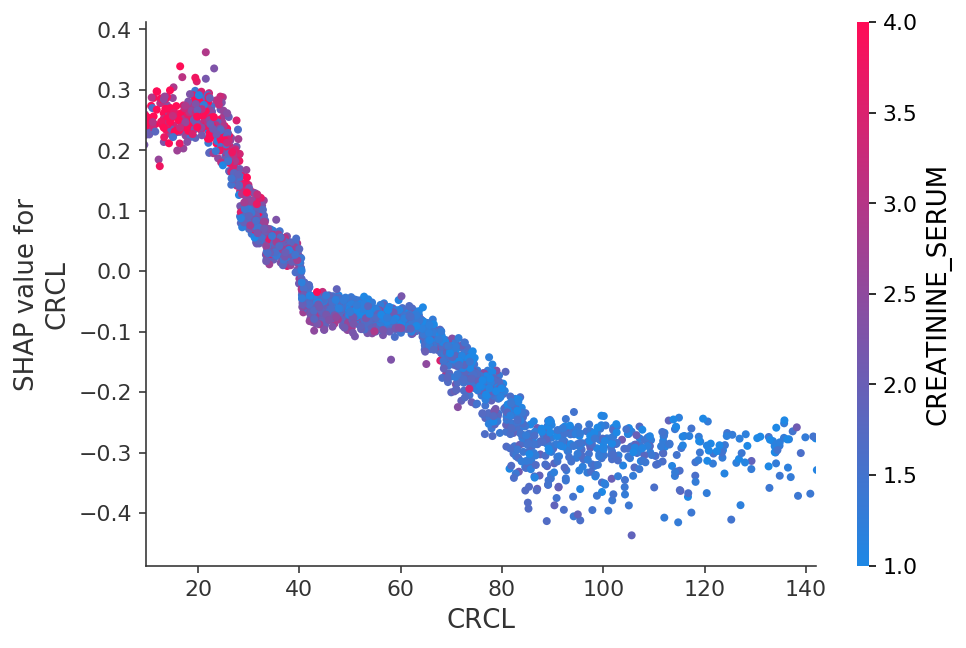

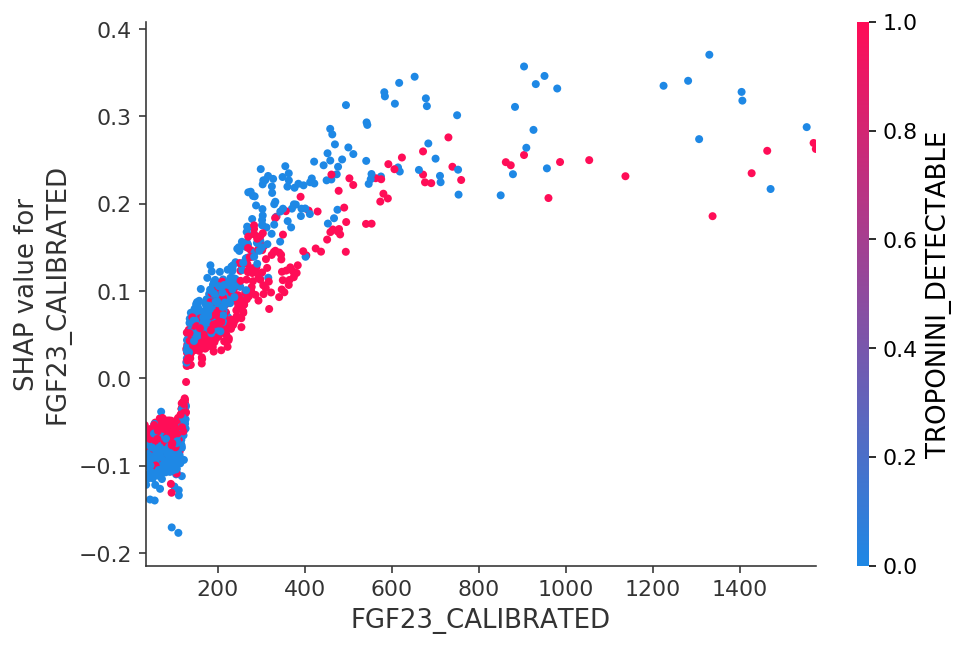

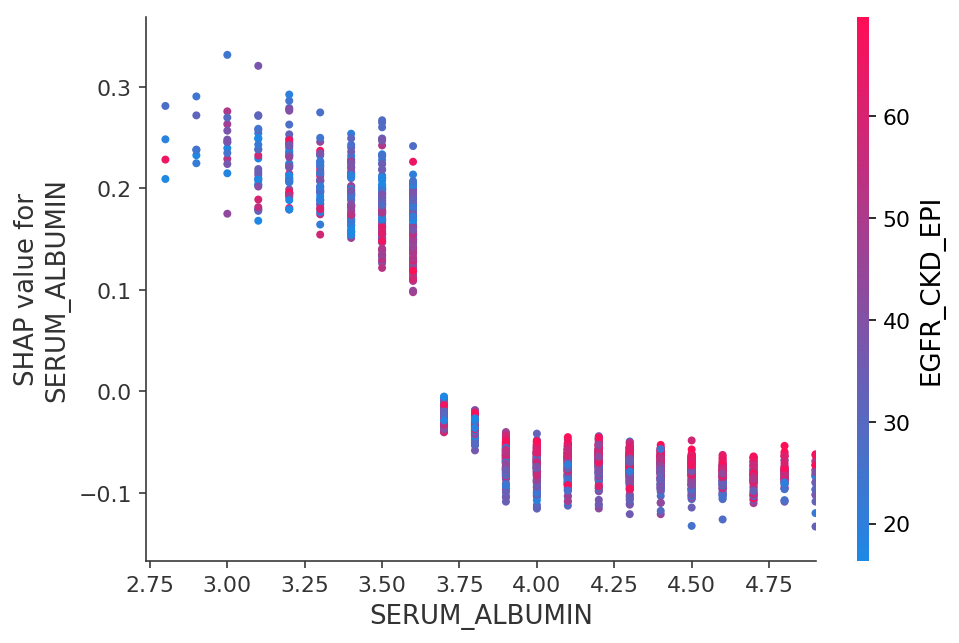

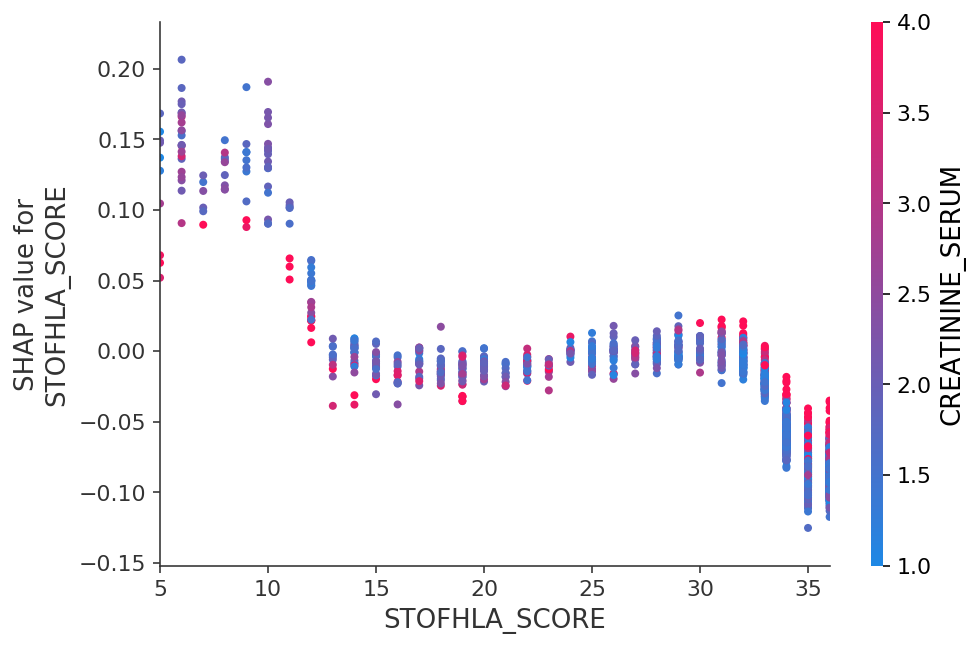

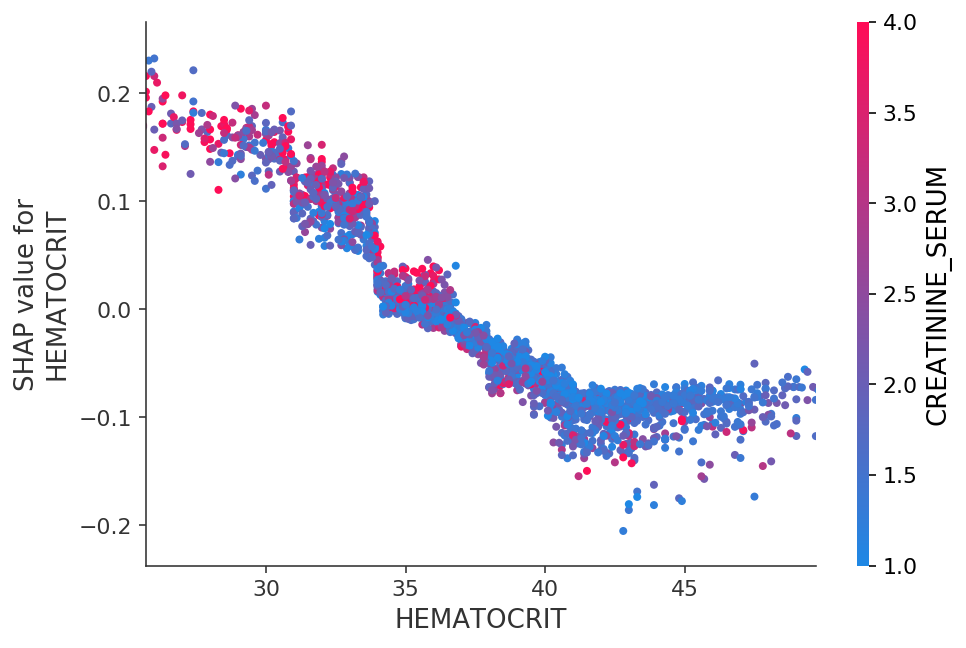

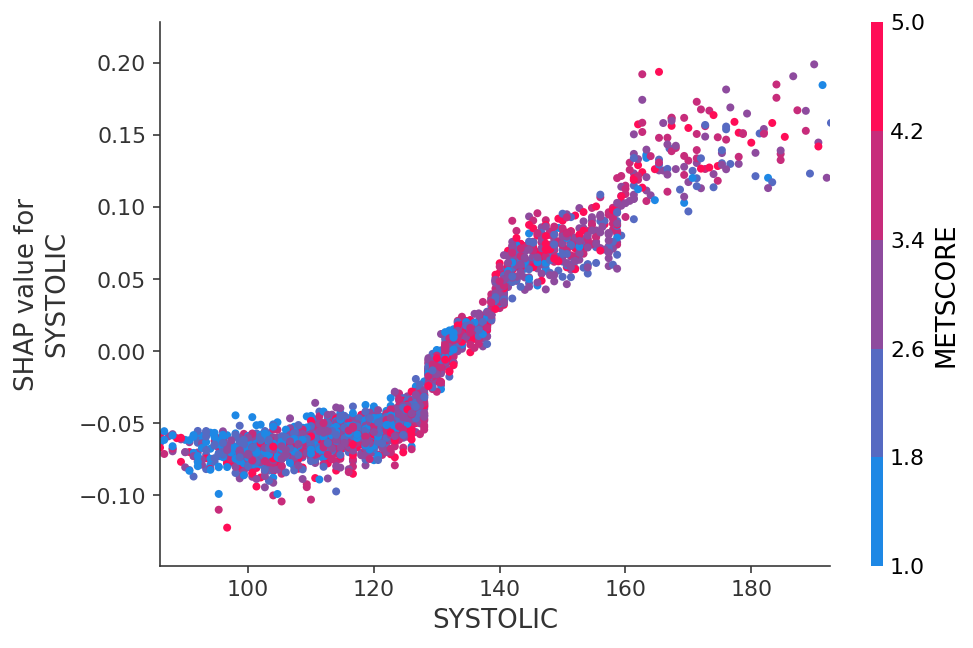

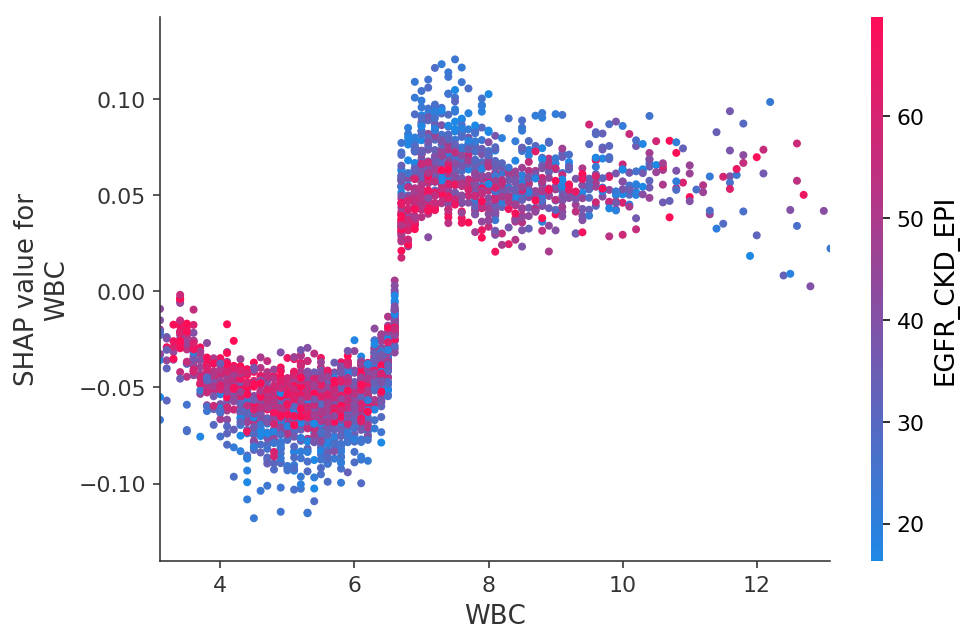

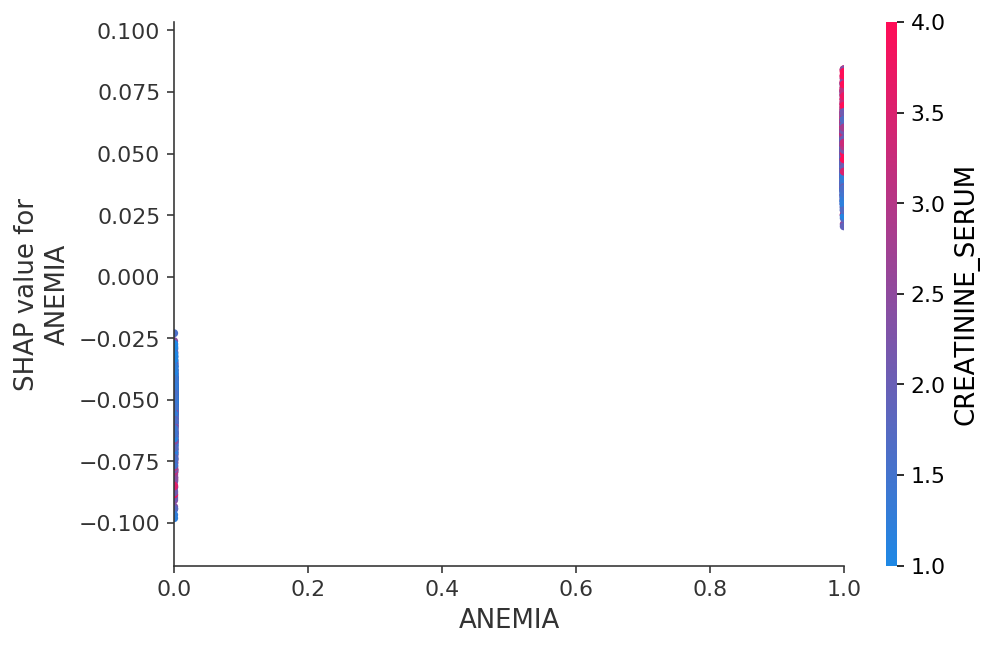

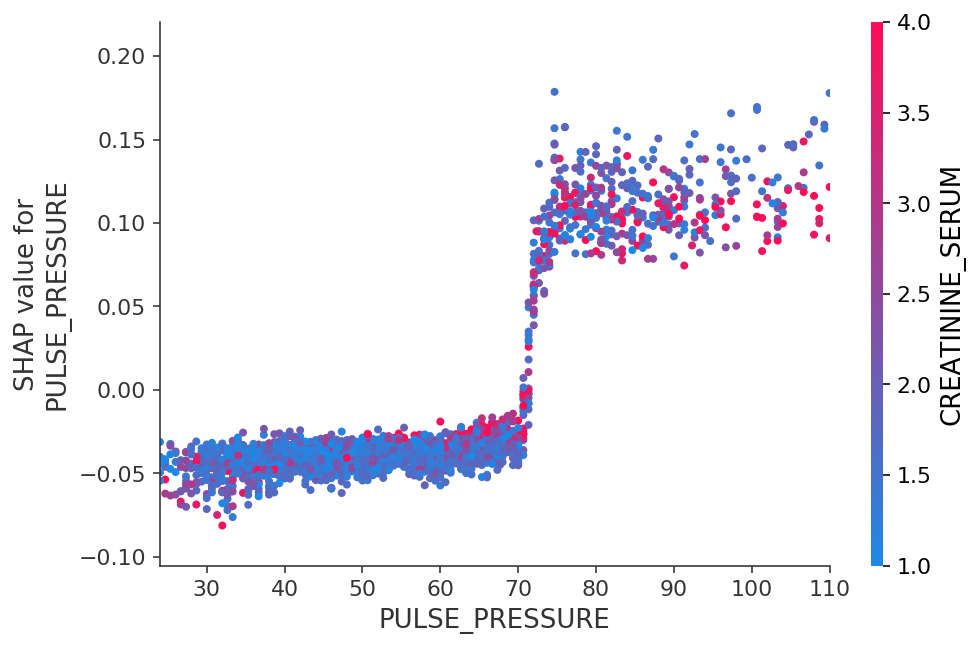

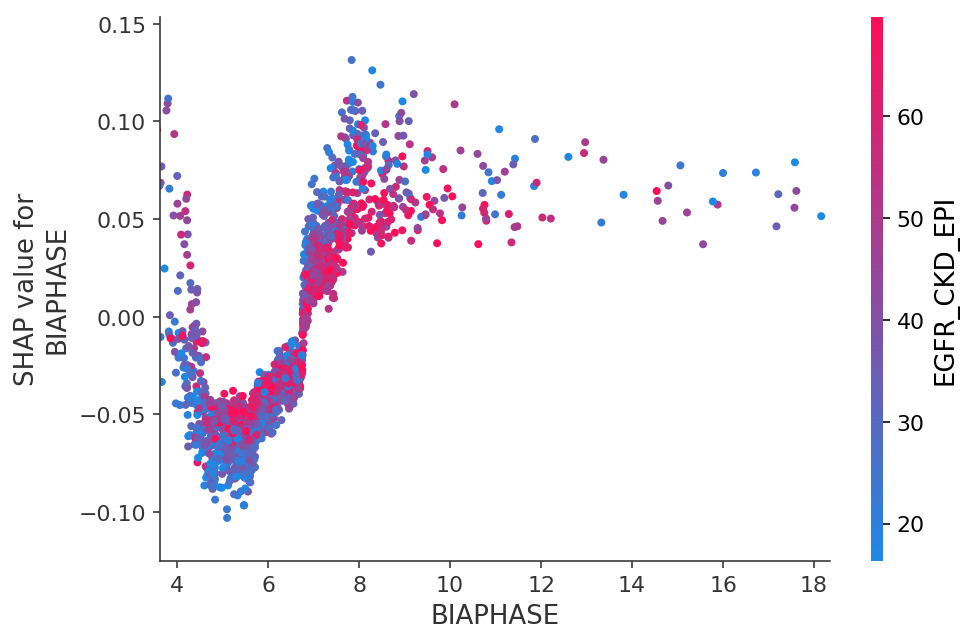

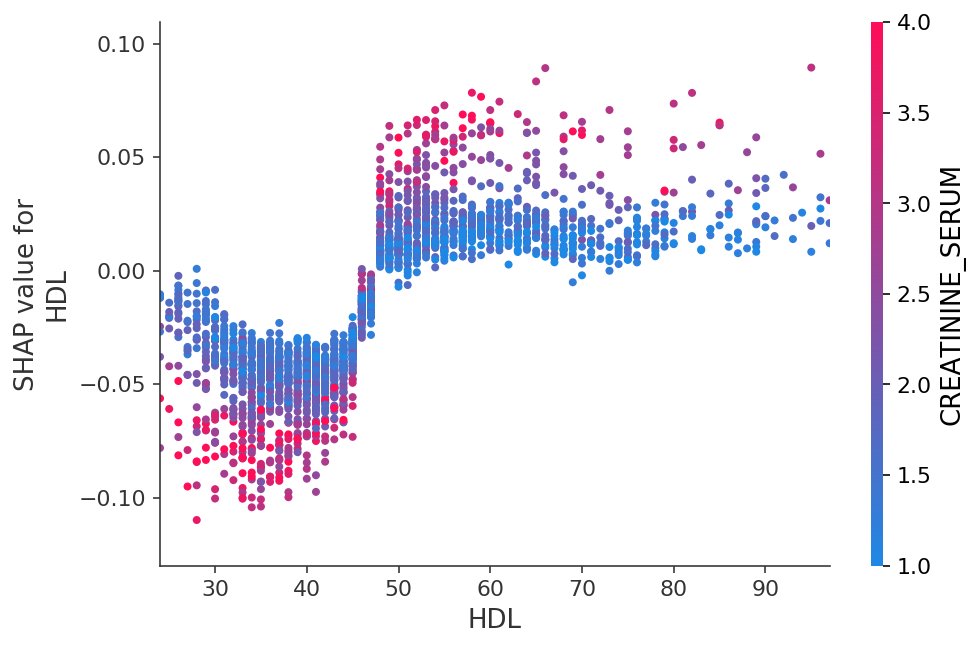

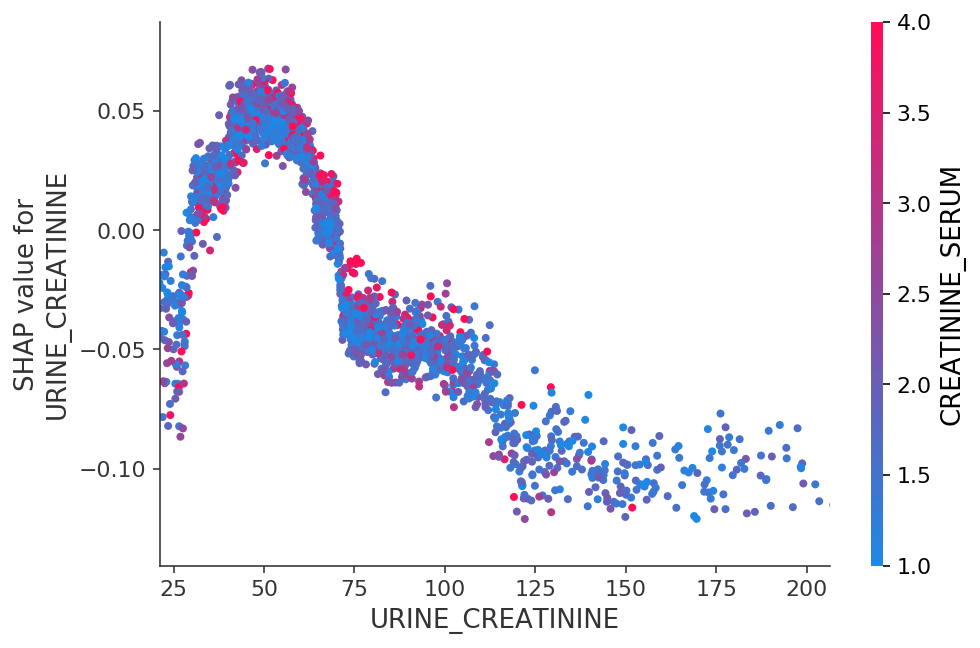

In [17]:
for i in np.argsort(-np.abs(xgb_shap).mean(0))[:20]:
    
    shap.dependence_plot(i, xgb_shap, X_test, show=False)
    pl.xlim(np.nanpercentile(X_test.values[:,i], 1), np.nanpercentile(X_test.values[:,i], 99))
    pl.show()

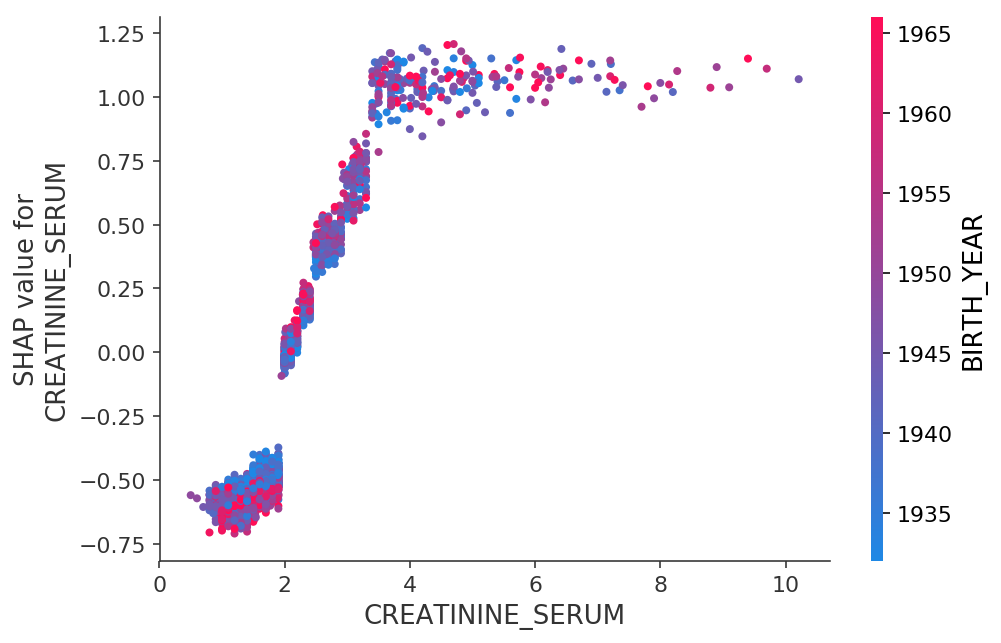

In [51]:
shap.dependence_plot("CREATININE_SERUM", xgb_shap, X_test)

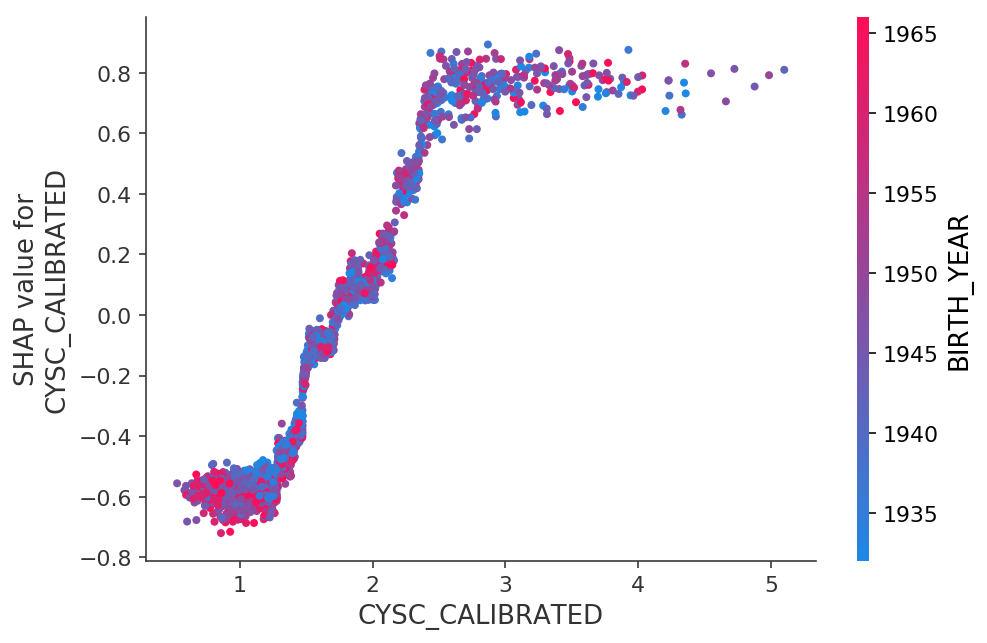

In [52]:
shap.dependence_plot("CYSC_CALIBRATED", xgb_shap, X_test)

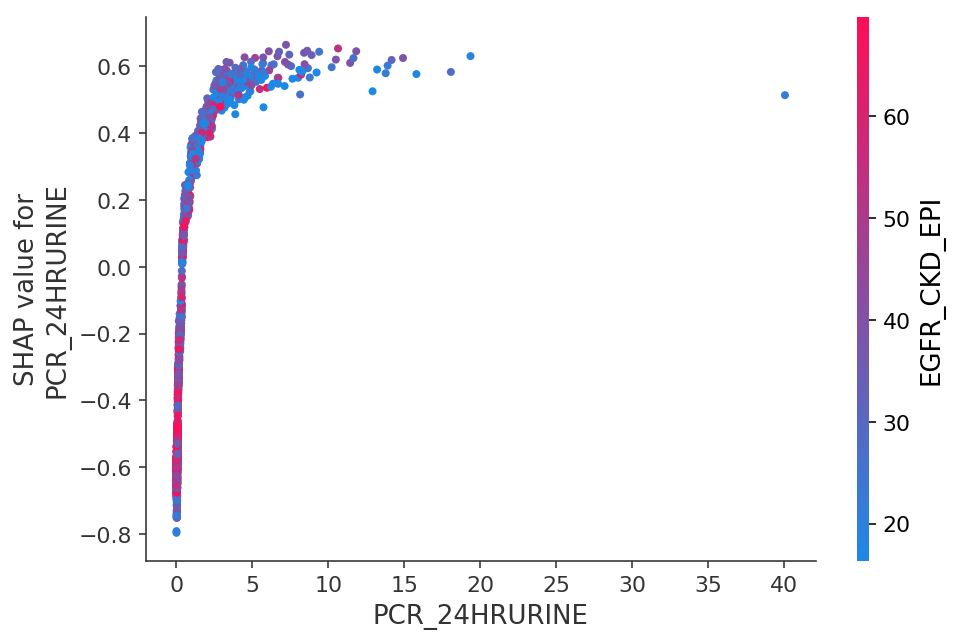

In [53]:
shap.dependence_plot("PCR_24HRURINE", xgb_shap, X_test)

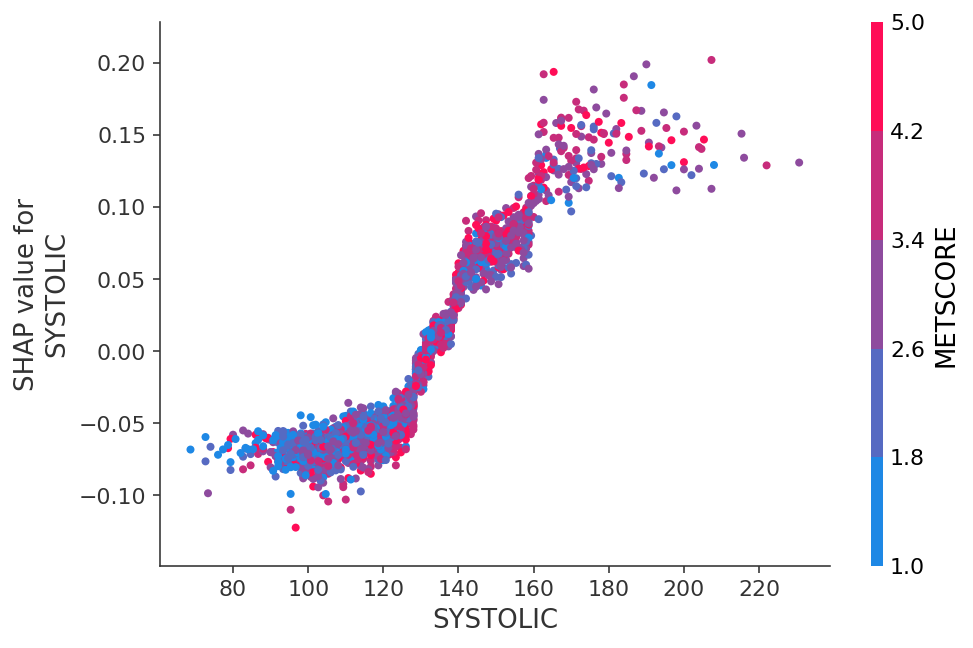

In [15]:
shap.dependence_plot("SYSTOLIC", xgb_shap, X_test)#, interaction_index="CREATININE_SERUM")

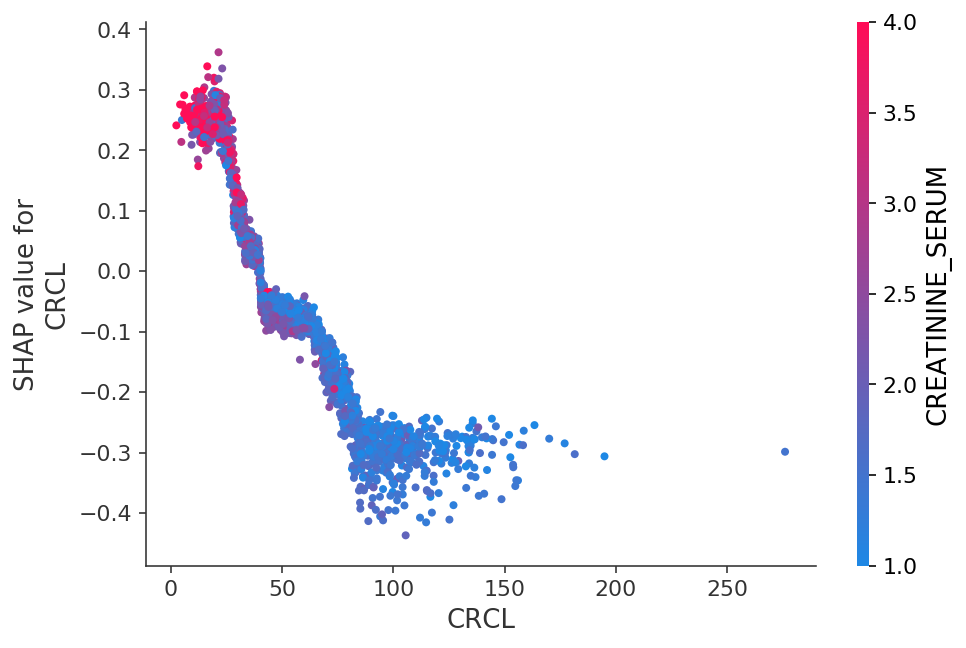

In [55]:
shap.dependence_plot("CRCL", xgb_shap, X_test)

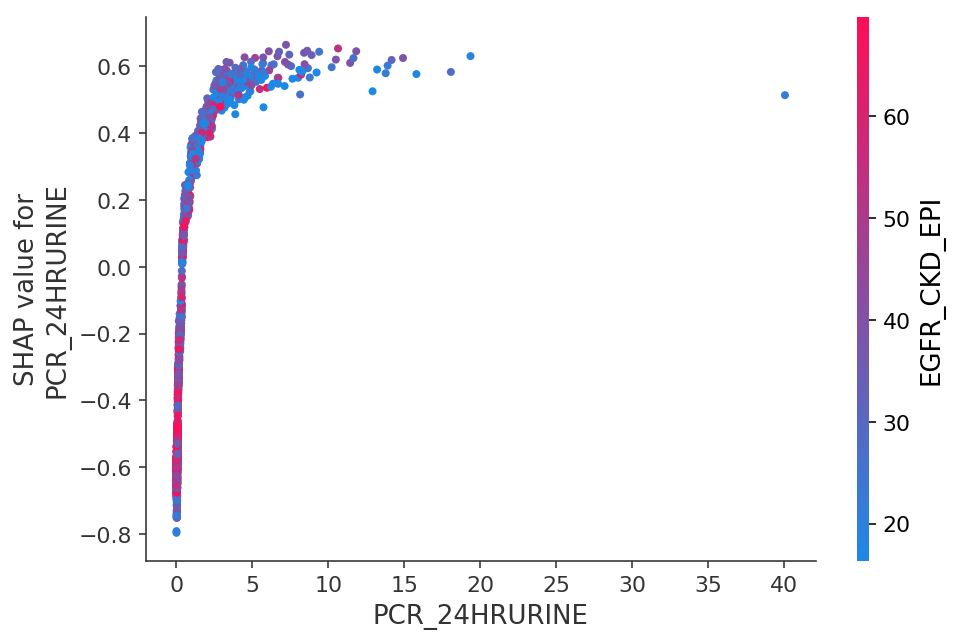

In [53]:
shap.dependence_plot("PCR_24HRURINE", xgb_shap, X_test)

Text(0.5,1,'ROC curves on CRIC test data')

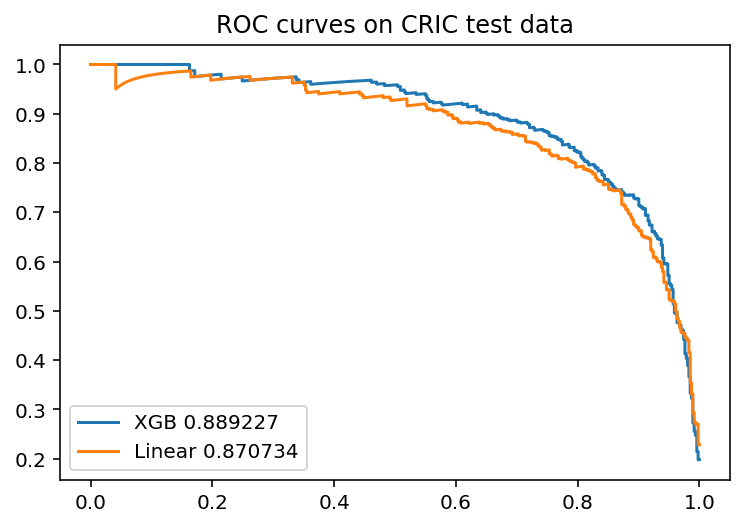

In [15]:
xgb_prauc = sklearn.metrics.average_precision_score(y_test, xgb_model.predict_proba(X_test)[:,1])
linear_prauc = sklearn.metrics.average_precision_score(y_test, linear_model.predict_proba(X_test_imp)[:,1])
#dnn_auc = sklearn.metrics.roc_auc_score(y_test, dnn_model.predict(X_test_imp))

xgb_fpr, xgb_tpr, thresholds = sklearn.metrics.precision_recall_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
linear_fpr, linear_tpr, thresholds = sklearn.metrics.precision_recall_curve(y_test, linear_model.predict_proba(X_test_imp)[:,1])
#dnn_fpr, dnn_tpr, thresholds = sklearn.metrics.roc_curve(y_test, dnn_model.predict(X_test_imp))


pl.plot(xgb_tpr, xgb_fpr, label="XGB %f" % xgb_prauc)
pl.plot(linear_tpr, linear_fpr, label="Linear %f" % linear_prauc)
#pl.plot(dnn_fpr, dnn_tpr, label="DNN %f" % dnn_auc)
pl.legend()
pl.title("ROC curves on CRIC test data")

Text(0.5,1,'ROC curves on CRIC test data')

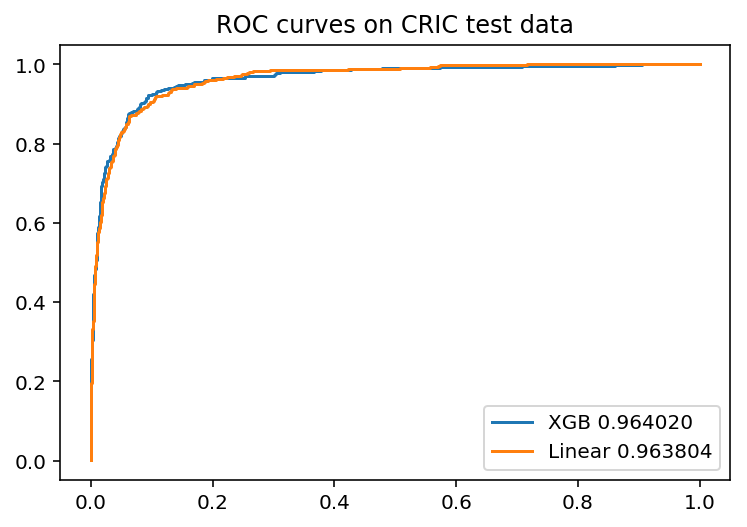

In [7]:
xgb_auc = sklearn.metrics.roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1])
linear_auc = sklearn.metrics.roc_auc_score(y_test, linear_model.predict_proba(X_test_imp)[:,1])
#dnn_auc = sklearn.metrics.roc_auc_score(y_test, dnn_model.predict(X_test_imp))

xgb_fpr, xgb_tpr, thresholds = sklearn.metrics.roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
linear_fpr, linear_tpr, thresholds = sklearn.metrics.roc_curve(y_test, linear_model.predict_proba(X_test_imp)[:,1])
#dnn_fpr, dnn_tpr, thresholds = sklearn.metrics.roc_curve(y_test, dnn_model.predict(X_test_imp))


pl.plot(xgb_fpr, xgb_tpr, label="XGB %f" % xgb_auc)
pl.plot(linear_fpr, linear_tpr, label="Linear %f" % linear_auc)
#pl.plot(dnn_fpr, dnn_tpr, label="DNN %f" % dnn_auc)
pl.legend()
pl.title("ROC curves on CRIC test data")

Text(0.5,1,'ROC curves on CRIC test data')

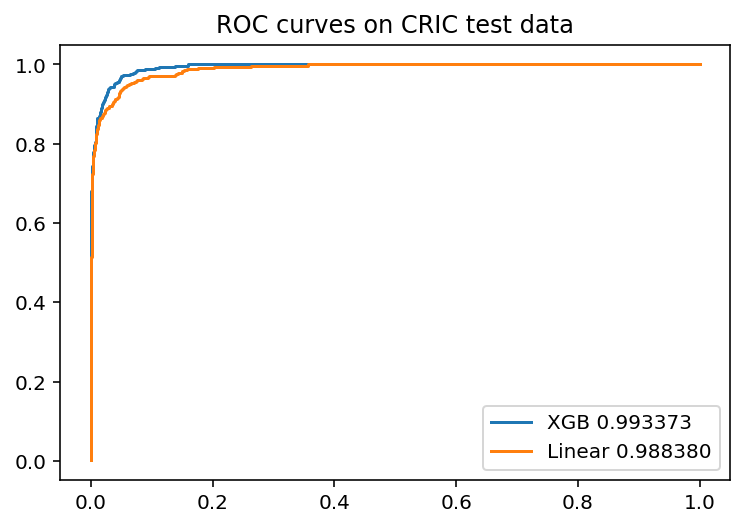

In [22]:
xgb_auc = sklearn.metrics.roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1])
linear_auc = sklearn.metrics.roc_auc_score(y_test, linear_model.predict_proba(X_test_imp)[:,1])
#dnn_auc = sklearn.metrics.roc_auc_score(y_test, dnn_model.predict(X_test_imp))

xgb_fpr, xgb_tpr, thresholds = sklearn.metrics.roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
linear_fpr, linear_tpr, thresholds = sklearn.metrics.roc_curve(y_test, linear_model.predict_proba(X_test_imp)[:,1])
#dnn_fpr, dnn_tpr, thresholds = sklearn.metrics.roc_curve(y_test, dnn_model.predict(X_test_imp))


pl.plot(xgb_fpr, xgb_tpr, label="XGB %f" % xgb_auc)
pl.plot(linear_fpr, linear_tpr, label="Linear %f" % linear_auc)
#pl.plot(dnn_fpr, dnn_tpr, label="DNN %f" % dnn_auc)
pl.legend()
pl.title("ROC curves on CRIC test data")

In [ ]:
pl.plot(out)
pl.show()

In [ ]:

dnn_auc = sklearn.metrics.roc_auc_score(y_test, model.predict(X_test))


In [17]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_test)

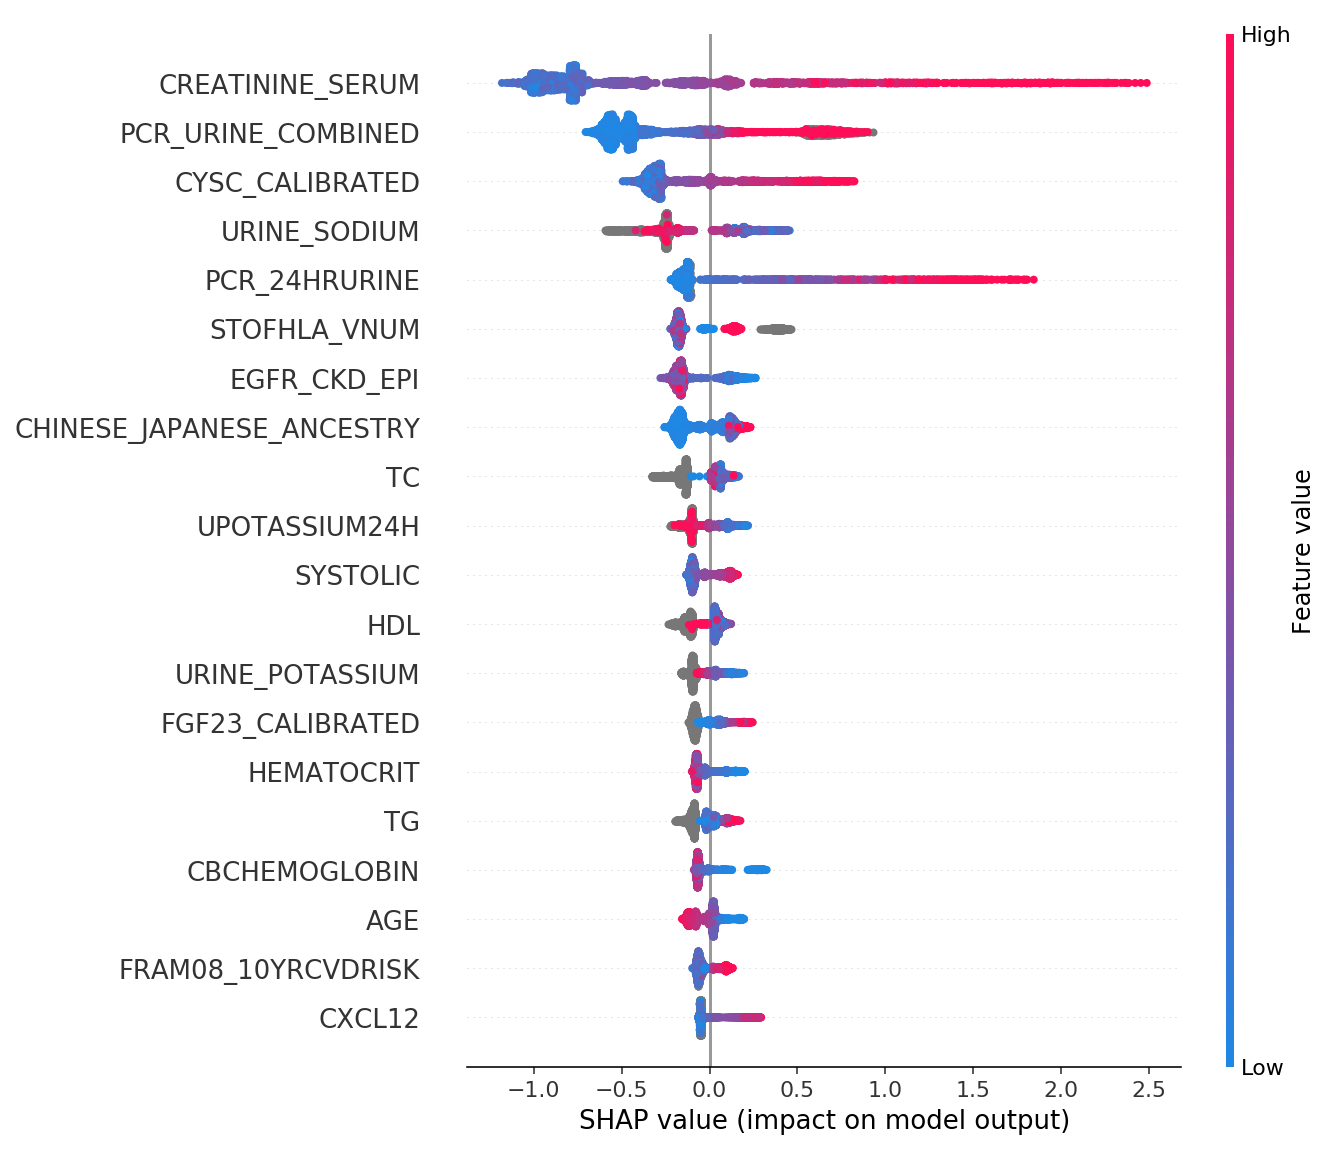

In [18]:
shap.summary_plot(shap_values, X_test)

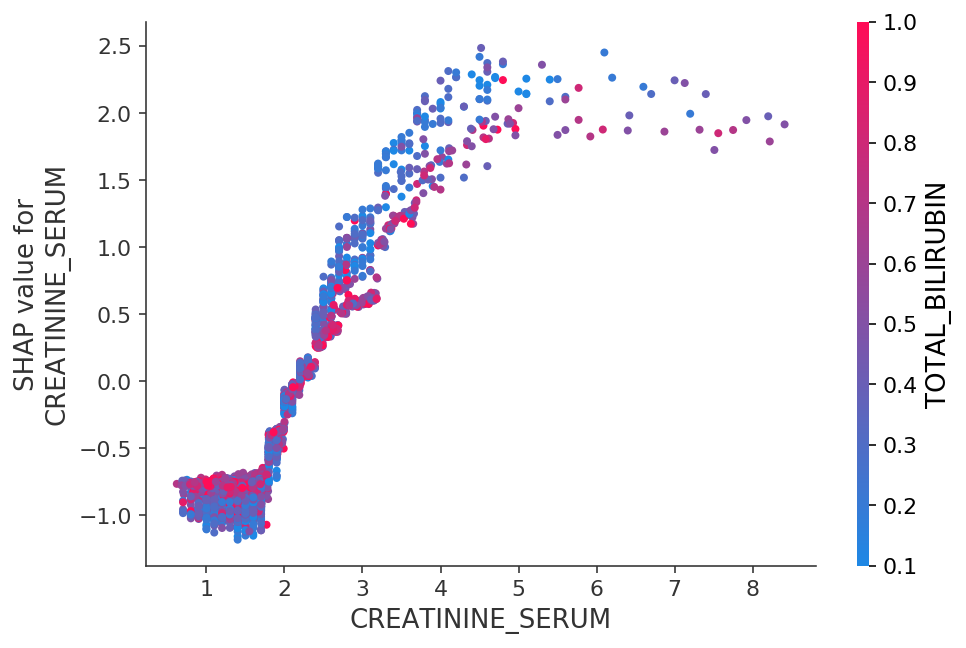

In [19]:
shap.dependence_plot("CREATININE_SERUM", shap_values, X_test)

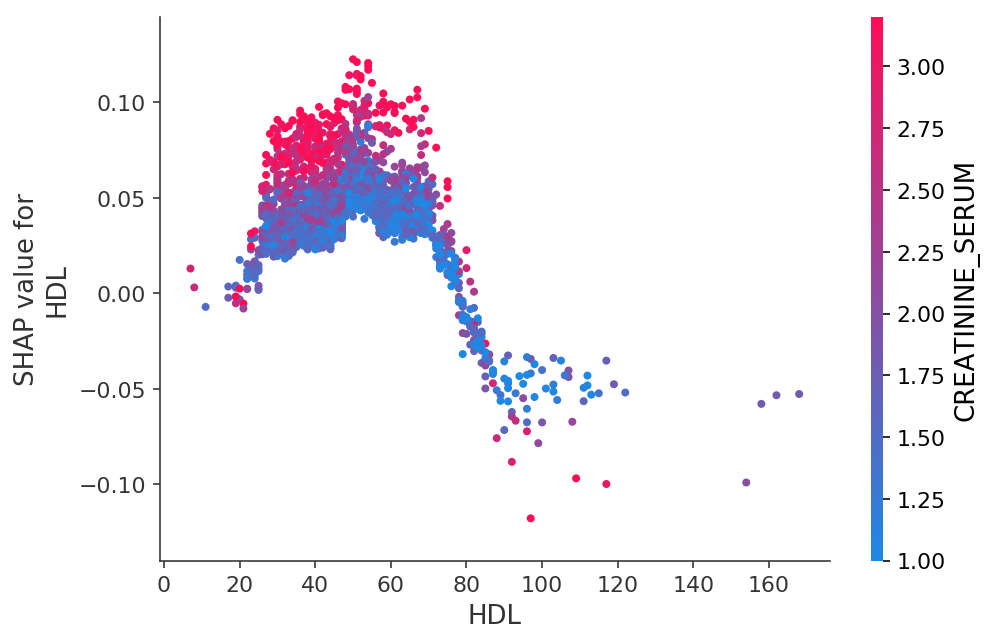

In [20]:
shap.dependence_plot("HDL", shap_values, X_test)

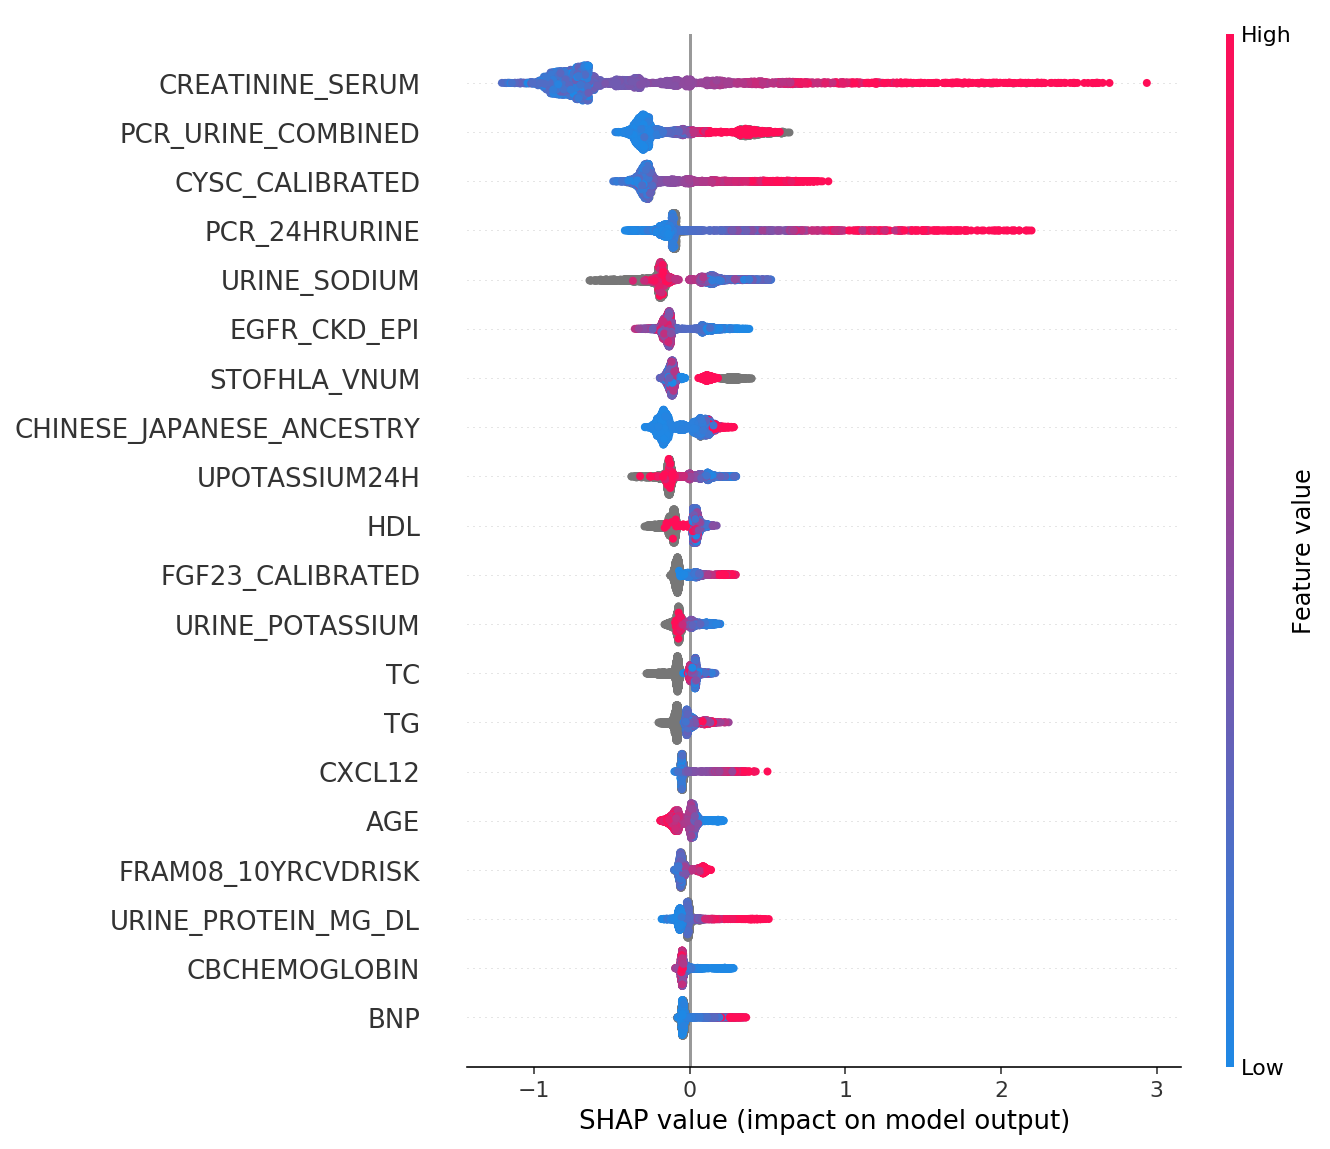

In [15]:
shap.summary_plot(shap_values, X_test)